In [1]:
import pandas as pd
import numpy as np
import ta
from scipy.stats import skew, kurtosis
from scipy.fft import fft, fftfreq
from scipy.signal import spectrogram
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import LinearRegression

import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 1. Load CSV dataset

In [2]:
# Load the dataset
file_path = 'dataset/BTCUSDT_15m_Aug2017-Oct2023.csv'
btc_data_raw = pd.read_csv(file_path)
btc_data_raw.head()

open_time  open_price  high_price  low_price  close_price     volume  \
0  1502943300000     4261.48     4270.41    4261.32      4261.45   9.119865   
1  1502944200000     4280.00     4310.07    4267.99      4310.07  21.923552   
2  1502945100000     4310.07     4313.62    4291.37      4308.83  13.948531   
3  1502946000000     4308.83     4328.69    4304.31      4304.31   5.101153   
4  1502946900000     4320.00     4320.00    4312.14      4320.00  15.947495   

      close_time  quote_asset_volume  number_of_trade  \
0  1502944199999        38891.133046               40   
1  1502945099999        94080.917568               58   
2  1502945999999        60060.466816               64   
3  1502946899999        22006.533111               44   
4  1502947799999        68857.759409               29   

   taker_buy_base_asset_volume  taker_buy_quote_asset_volume       ignore  
0                     3.447113                  14703.934995  7922.579933  
1                    20.421317                  87620.977876  7912.494217  
2                    10.803012                  46538.460109  7887.635513  
3                     3.496635                  15093.783057  7865.654419  
4                    15.899935                  68652.300685  7863.871184

In [3]:
btc_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216979 entries, 0 to 216978
Data columns (total 12 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   open_time                     216979 non-null  int64  
 1   open_price                    216979 non-null  float64
 2   high_price                    216979 non-null  float64
 3   low_price                     216979 non-null  float64
 4   close_price                   216979 non-null  float64
 5   volume                        216979 non-null  float64
 6   close_time                    216979 non-null  int64  
 7   quote_asset_volume            216979 non-null  float64
 8   number_of_trade               216979 non-null  int64  
 9   taker_buy_base_asset_volume   216979 non-null  float64
 10  taker_buy_quote_asset_volume  216979 non-null  float64
 11  ignore                        216979 non-null  float64
dtypes: float64(9), int64(3)
memory usage: 19.9 M

# 2. Resample dataset and handle missing values

### Resampling rules on missing values
These columns should all be replace with previous `close_price` value
- open_price
- high_price
- low_price
- close_price

This 2 columns should follow the datetime of the resampled row:
- open_time
- close_time

All of this remaining columns should be `0`:
- quote_asset_volume
- number_of_trade
- taker_buy_base_asset_volume
- taker_buy_quote_asset_volume
- ignore

In [4]:
btc_data = btc_data_raw.copy()

# Convert the timestamps to a more readable format
btc_data['open_time'] = pd.to_datetime(btc_data['open_time'], unit='ms')
btc_data['close_time'] = pd.to_datetime(btc_data['close_time'], unit='ms')

# Set 'open_time' as the index for resampling
btc_data.set_index('open_time', inplace=True)

In [5]:
btc_data.head()

open_price  high_price  low_price  close_price  \
open_time                                                             
2017-08-17 04:15:00     4261.48     4270.41    4261.32      4261.45   
2017-08-17 04:30:00     4280.00     4310.07    4267.99      4310.07   
2017-08-17 04:45:00     4310.07     4313.62    4291.37      4308.83   
2017-08-17 05:00:00     4308.83     4328.69    4304.31      4304.31   
2017-08-17 05:15:00     4320.00     4320.00    4312.14      4320.00   

                        volume              close_time  quote_asset_volume  \
open_time                                                                    
2017-08-17 04:15:00   9.119865 2017-08-17 04:29:59.999        38891.133046   
2017-08-17 04:30:00  21.923552 2017-08-17 04:44:59.999        94080.917568   
2017-08-17 04:45:00  13.948531 2017-08-17 04:59:59.999        60060.466816   
2017-08-17 05:00:00   5.101153 2017-08-17 05:14:59.999        22006.533111   
2017-08-17 05:15:00  15.947495 2017-08-17 05:29:59.999        68857.759409   

                     number_of_trade  taker_buy_base_asset_volume  \
open_time                                                           
2017-08-17 04:15:00               40                     3.447113   
2017-08-17 04:30:00               58                    20.421317   
2017-08-17 04:45:00               64                    10.803012   
2017-08-17 05:00:00               44                     3.496635   
2017-08-17 05:15:00               29                    15.899935   

                     taker_buy_quote_asset_volume       ignore  
open_time                                                       
2017-08-17 04:15:00                  14703.934995  7922.579933  
2017-08-17 04:30:00                  87620.977876  7912.494217  
2017-08-17 04:45:00                  46538.460109  7887.635513  
2017-08-17 05:00:00                  15093.783057  7865.654419  
2017-08-17 05:15:00                  68652.300685  7863.871184

In [6]:
# Resampling the data by 15 minutes without forward filling initially
resampled_data = btc_data.resample('15T').asfreq()

# Forward filling the 'close_price' and using it for other prices
resampled_data['close_price'] = resampled_data['close_price'].ffill()
resampled_data['shifted_close_price'] = resampled_data['close_price'].shift(1)

# Filling missing 'open_price' values with the shifted 'close_price'
resampled_data['open_price'] = resampled_data['open_price'].fillna(resampled_data['shifted_close_price'])
resampled_data['high_price'] = resampled_data['high_price'].fillna(resampled_data['shifted_close_price'])
resampled_data['low_price'] = resampled_data['low_price'].fillna(resampled_data['shifted_close_price'])
resampled_data.drop('shifted_close_price', axis=1, inplace=True)

# Setting other columns to zero
columns_to_zero = ['volume', 'quote_asset_volume', 'number_of_trade', 
                   'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']
resampled_data[columns_to_zero] = resampled_data[columns_to_zero].fillna(0)

# Updating 'open_time' and 'close_time' columns
# resampled_data.reset_index(inplace=True)
resampled_data.drop('close_time', axis=1, inplace=True)

In [7]:
resampled_data.head()

open_price  high_price  low_price  close_price  \
open_time                                                             
2017-08-17 04:15:00     4261.48     4270.41    4261.32      4261.45   
2017-08-17 04:30:00     4280.00     4310.07    4267.99      4310.07   
2017-08-17 04:45:00     4310.07     4313.62    4291.37      4308.83   
2017-08-17 05:00:00     4308.83     4328.69    4304.31      4304.31   
2017-08-17 05:15:00     4320.00     4320.00    4312.14      4320.00   

                        volume  quote_asset_volume  number_of_trade  \
open_time                                                             
2017-08-17 04:15:00   9.119865        38891.133046             40.0   
2017-08-17 04:30:00  21.923552        94080.917568             58.0   
2017-08-17 04:45:00  13.948531        60060.466816             64.0   
2017-08-17 05:00:00   5.101153        22006.533111             44.0   
2017-08-17 05:15:00  15.947495        68857.759409             29.0   

                     taker_buy_base_asset_volume  \
open_time                                          
2017-08-17 04:15:00                     3.447113   
2017-08-17 04:30:00                    20.421317   
2017-08-17 04:45:00                    10.803012   
2017-08-17 05:00:00                     3.496635   
2017-08-17 05:15:00                    15.899935   

                     taker_buy_quote_asset_volume       ignore  
open_time                                                       
2017-08-17 04:15:00                  14703.934995  7922.579933  
2017-08-17 04:30:00                  87620.977876  7912.494217  
2017-08-17 04:45:00                  46538.460109  7887.635513  
2017-08-17 05:00:00                  15093.783057  7865.654419  
2017-08-17 05:15:00                  68652.300685  7863.871184

# 3. Feature Extraction

## 3.1 Add more features
1. Lag features: 15 min, 30 min, 1 hour, 3 hour, 6 hour, 12 hour, 1 day, 3 day, 5 day, 7 day
2. Rolling window statistic including means, medians, variances, minimum, and maximum values of the `close_price` for 15 min, 30 min, 1 hour, 3 hour, 6 hour, 12 hour, 1 day, 3 day, 5 day, 7 day
3. Rolling window statistic including means, medians, variances, minimum, and maximum values of the `volume`  for 15 min, 30 min, 1 hour, 3 hour, 6 hour, 12 hour, 1 day, 3 day, 5 day, 7 day
4. Price Change over each time period: 15 min, 30 min, 1 hour, 3 hour, 6 hour
5. Technical Indicators: SMA, EMA, RSI, MACD, and Bollinger Bands
6. Frequency Domain with Fourier Transformation
7. Date and Time Components with SinCos Transformation

In [60]:
# Function to calculate rolling window statistics and concatenate them
def rolling_window_stats(df, column, windows):
    new_cols = {}
    for window in windows:
        roll = df[column].rolling(window)
        new_cols[f'{column}_mean_{window}'] = roll.mean()
        new_cols[f'{column}_median_{window}'] = roll.median()
        new_cols[f'{column}_var_{window}'] = roll.var()
        new_cols[f'{column}_std_{window}'] = roll.std()
        new_cols[f'{column}_min_{window}'] = roll.min()
        new_cols[f'{column}_max_{window}'] = roll.max()
        # TOOD: optimize the following two lines to compute skewness and kurtosis faster
        # new_cols[f'{column}_skewness_{window}'] = roll.apply(lambda x: x.skew(), raw=False)
        # new_cols[f'{column}_kurtosis_{window}'] = roll.apply(lambda x: x.kurtosis(), raw=False)
        # new_cols[f'{column}_skew_{window}'] = roll.apply(lambda x: skew(x, bias=False), raw=True)
        # new_cols[f'{column}_kurt_{window}'] = roll.apply(lambda x: kurtosis(x, fisher=True, bias=False), raw=True)
    return pd.concat(new_cols, axis=1)

# Function to calculate price change
def price_change(df, column, windows):
    new_cols = {}
    for window in windows:
        new_cols[f'{column}_change_{window}'] = df[column].pct_change(periods=window)
    return pd.DataFrame(new_cols)

# Function to calculate SinCos Transforms
def sincos_transforms(df, component_mappings: dict):
    new_cols = {}
    for column, total_period in component_mappings.items():
        new_cols[f'{column}_sin'] = np.sin(2 * np.pi * df[column] / total_period)
        new_cols[f'{column}_cos'] = np.cos(2 * np.pi * df[column] / total_period)
    return pd.DataFrame(new_cols)

In [82]:
feature_extracted_data = resampled_data.copy()

# Time intervals in 15-minutes for features
time_intervals = [1, 2, 4, 12, 24, 48, 96, 288, 480, 672]  # 15 min, 30 min, 1 hour, 3 hour, 6 hour, 12 hour, 1 day, 3 day, 5 day, 7 day
rolling_time_intervals = [2, 4, 12, 24, 48, 96, 288, 480, 672]  # 30 min, 1 hour, 3 hour, 6 hour, 12 hour, 1 day, 3 day, 5 day, 7 day

# 1. Lag features
lag_cols = {f'close_price_lag_{interval}': feature_extracted_data['close_price'].shift(interval) for interval in time_intervals}
feature_extracted_data = pd.concat([feature_extracted_data, pd.DataFrame(lag_cols)], axis=1)

# 2. Rolling window statistics for 'close_price'
# TODO: remove earily time intervals from the list
df_rolling_window_close_price = rolling_window_stats(feature_extracted_data, 'close_price', rolling_time_intervals)
feature_extracted_data = pd.concat([feature_extracted_data, df_rolling_window_close_price], axis=1)

# 3. Rolling window statistics for 'volume'
# TODO: remove earily time intervals from the list
df_rolling_window_volume = rolling_window_stats(feature_extracted_data, 'volume', rolling_time_intervals)
feature_extracted_data = pd.concat([feature_extracted_data, df_rolling_window_volume], axis=1)

# 4. Price Change
# TODO: remove earily time intervals from the list
df_price_change = price_change(feature_extracted_data, 'close_price', rolling_time_intervals)
feature_extracted_data = pd.concat([feature_extracted_data, df_price_change], axis=1)

# 5. Technical Indicators: SMA, EMA, RSI, MACD, and Bollinger Bands
# source: https://technical-analysis-library-in-python.readthedocs.io/en/latest/
feature_extracted_data['close_price_SMA'] = ta.trend.sma_indicator(feature_extracted_data['close_price'])
feature_extracted_data['close_price_EMA'] = ta.trend.ema_indicator(feature_extracted_data['close_price'])
feature_extracted_data['close_price_MACD'] = ta.trend.macd(feature_extracted_data['close_price'])
feature_extracted_data['close_price_RSI'] = ta.momentum.rsi(feature_extracted_data['close_price'])
feature_extracted_data['close_price_Bollinger_mavg'] = ta.volatility.bollinger_mavg(feature_extracted_data['close_price'])
feature_extracted_data['close_price_Bollinger_hband'] = ta.volatility.bollinger_hband(feature_extracted_data['close_price'])
feature_extracted_data['close_price_Bollinger_lband'] = ta.volatility.bollinger_lband(feature_extracted_data['close_price'])

# 6. Frequency Domain Features Extraction
# 6.1 Fourier Transform on 'close_price'
yf = fft(feature_extracted_data['close_price'].values.tolist())
feature_extracted_data['close_price_fourier_real'] = yf.real
feature_extracted_data['close_price_fourier_imag'] = yf.imag

# 6.2 Spectrogram on 'close_price'
# TODO: how can we apply spectrogram on a time series data?
# fs = 96  # sampling frequency (15-min intervals = 96 data points per day)
# frequencies, times, Sxx = spectrogram(feature_extracted_data['close_price'], fs)

# 7.1 Date and Time Components
feature_extracted_data['minute'] = feature_extracted_data.index.minute
feature_extracted_data['hour'] = feature_extracted_data.index.hour
feature_extracted_data['day_of_month'] = feature_extracted_data.index.day
feature_extracted_data['day_of_week'] = feature_extracted_data.index.dayofweek
feature_extracted_data['week'] = feature_extracted_data.index.isocalendar().week
feature_extracted_data['month'] = feature_extracted_data.index.month
feature_extracted_data['year'] = feature_extracted_data.index.year

# 7.2. Seasonality Indicators: Sin and Cos Transformation on datetime cyclic features
datetime_component_mappings = {
    'minute': 60,
    'hour': 24,
    'day_of_month': 31,
    'day_of_week': 7,
    'week': 52,
    'month': 12,
}
df_datetime_sincos = sincos_transforms(feature_extracted_data, datetime_component_mappings)
feature_extracted_data = pd.concat([feature_extracted_data, df_datetime_sincos], axis=1)

# 7.3. Year is not quite a cyclic feature, so we will not apply SinCos transform on it directly
year_cycle_period = 4  # assumption from BTC's 4-year halving cycle
feature_extracted_data['year_cycle'] = (feature_extracted_data['year'] - feature_extracted_data['year'].min()) % year_cycle_period
df_year_sincos = sincos_transforms(feature_extracted_data, {'year_cycle': year_cycle_period})
feature_extracted_data = pd.concat([feature_extracted_data, df_year_sincos], axis=1)

# show the data
feature_extracted_data

open_price  high_price  low_price  close_price  \
open_time                                                             
2017-08-17 04:15:00     4261.48     4270.41    4261.32      4261.45   
2017-08-17 04:30:00     4280.00     4310.07    4267.99      4310.07   
2017-08-17 04:45:00     4310.07     4313.62    4291.37      4308.83   
2017-08-17 05:00:00     4308.83     4328.69    4304.31      4304.31   
2017-08-17 05:15:00     4320.00     4320.00    4312.14      4320.00   
...                         ...         ...        ...          ...   
2023-10-31 22:45:00    34603.45    34614.43   34551.77     34559.15   
2023-10-31 23:00:00    34559.16    34583.69   34516.04     34566.08   
2023-10-31 23:15:00    34566.08    34594.64   34566.07     34594.63   
2023-10-31 23:30:00    34594.64    34629.06   34584.12     34623.37   
2023-10-31 23:45:00    34623.37    34658.35   34601.66     34639.77   

                         volume  quote_asset_volume  number_of_trade  \
open_time                                                              
2017-08-17 04:15:00    9.119865        3.889113e+04             40.0   
2017-08-17 04:30:00   21.923552        9.408092e+04             58.0   
2017-08-17 04:45:00   13.948531        6.006047e+04             64.0   
2017-08-17 05:00:00    5.101153        2.200653e+04             44.0   
2017-08-17 05:15:00   15.947495        6.885776e+04             29.0   
...                         ...                 ...              ...   
2023-10-31 22:45:00  231.747580        8.014559e+06           7681.0   
2023-10-31 23:00:00  329.948240        1.140312e+07           9386.0   
2023-10-31 23:15:00  241.811780        8.362124e+06           6563.0   
2023-10-31 23:30:00  238.521140        8.256545e+06           8273.0   
2023-10-31 23:45:00  277.399370        9.608889e+06           9567.0   

                     taker_buy_base_asset_volume  \
open_time                                          
2017-08-17 04:15:00                     3.447113   
2017-08-17 04:30:00                    20.421317   
2017-08-17 04:45:00                    10.803012   
2017-08-17 05:00:00                     3.496635   
2017-08-17 05:15:00                    15.899935   
...                                          ...   
2023-10-31 22:45:00                    98.136360   
2023-10-31 23:00:00                   176.233620   
2023-10-31 23:15:00                   138.453990   
2023-10-31 23:30:00                   101.620910   
2023-10-31 23:45:00                   166.417070   

                     taker_buy_quote_asset_volume       ignore  ...  \
open_time                                                       ...   
2017-08-17 04:15:00                  1.470393e+04  7922.579933  ...   
2017-08-17 04:30:00                  8.762098e+04  7912.494217  ...   
2017-08-17 04:45:00                  4.653846e+04  7887.635513  ...   
2017-08-17 05:00:00                  1.509378e+04  7865.654419  ...   
2017-08-17 05:15:00                  6.865230e+04  7863.871184  ...   
...                                           ...          ...  ...   
2023-10-31 22:45:00                  3.393550e+06     0.000000  ...   
2023-10-31 23:00:00                  6.090783e+06     0.000000  ...   
2023-10-31 23:15:00                  4.787730e+06     0.000000  ...   
2023-10-31 23:30:00                  3.517480e+06     0.000000  ...   
2023-10-31 23:45:00                  5.764385e+06     0.000000  ...   

                     day_of_month_cos  day_of_week_sin  day_of_week_cos  \
open_time                                                                 
2017-08-17 04:15:00         -0.954139         0.433884        -0.900969   
2017-08-17 04:30:00         -0.954139         0.433884        -0.900969   
2017-08-17 04:45:00         -0.954139         0.433884        -0.900969   
2017-08-17 05:00:00         -0.954139         0.433884        -0.900969   
2017-08-17 05:15:00         -0.954139         0.433884        -0.900969   
...                               

## 3.2 Post-processing data: handling missing values

In [83]:
# check for missing values after feature extraction

# count Nan values in each column
for col, val in feature_extracted_data.isna().sum().items():
    if val >= 600:
        print(col, val)

# show rows with missing values after feature extraction
feature_extracted_data[feature_extracted_data.isna().any(axis=1)]

close_price_lag_672 672
close_price_mean_672 671
close_price_median_672 671
close_price_var_672 671
close_price_std_672 671
close_price_min_672 671
close_price_max_672 671
volume_mean_672 671
volume_median_672 671
volume_var_672 671
volume_std_672 671
volume_min_672 671
volume_max_672 671
close_price_change_672 672


open_price  high_price  low_price  close_price  \
open_time                                                             
2017-08-17 04:15:00     4261.48     4270.41    4261.32      4261.45   
2017-08-17 04:30:00     4280.00     4310.07    4267.99      4310.07   
2017-08-17 04:45:00     4310.07     4313.62    4291.37      4308.83   
2017-08-17 05:00:00     4308.83     4328.69    4304.31      4304.31   
2017-08-17 05:15:00     4320.00     4320.00    4312.14      4320.00   
...                         ...         ...        ...          ...   
2017-08-24 03:00:00     4146.97     4163.59    4113.79      4113.79   
2017-08-24 03:15:00     4113.79     4163.52    4097.83      4130.00   
2017-08-24 03:30:00     4109.74     4134.48    4085.01      4113.49   
2017-08-24 03:45:00     4131.75     4149.00    4113.49      4113.58   
2017-08-24 04:00:00     4113.58     4148.19    4100.06      4100.06   

                        volume  quote_asset_volume  number_of_trade  \
open_time                                                             
2017-08-17 04:15:00   9.119865        38891.133046             40.0   
2017-08-17 04:30:00  21.923552        94080.917568             58.0   
2017-08-17 04:45:00  13.948531        60060.466816             64.0   
2017-08-17 05:00:00   5.101153        22006.533111             44.0   
2017-08-17 05:15:00  15.947495        68857.759409             29.0   
...                        ...                 ...              ...   
2017-08-24 03:00:00   7.576849        31332.550710             50.0   
2017-08-24 03:15:00  10.298225        42431.304648             52.0   
2017-08-24 03:30:00  10.156426        41714.141305             44.0   
2017-08-24 03:45:00   6.981134        28850.525866             38.0   
2017-08-24 04:00:00   7.491000        30931.762353             71.0   

                     taker_buy_base_asset_volume  \
open_time                                          
2017-08-17 04:15:00                     3.447113   
2017-08-17 04:30:00                    20.421317   
2017-08-17 04:45:00                    10.803012   
2017-08-17 05:00:00                     3.496635   
2017-08-17 05:15:00                    15.899935   
...                                          ...   
2017-08-24 03:00:00                     2.536324   
2017-08-24 03:15:00                     3.062708   
2017-08-24 03:30:00                     4.088488   
2017-08-24 03:45:00                     2.302830   
2017-08-24 04:00:00                     3.938795   

                     taker_buy_quote_asset_volume        ignore  ...  \
open_time                                                        ...   
2017-08-17 04:15:00                  14703.934995   7922.579933  ...   
2017-08-17 04:30:00                  87620.977876   7912.494217  ...   
2017-08-17 04:45:00                  46538.460109   7887.635513  ...   
2017-08-17 05:00:00                  15093.783057   7865.654419  ...   
2017-08-17 05:15:00                  68652.300685   7863.871184  ...   
...                                           ...           ...  ...   
2017-08-24 03:00:00                  10524.584880  12744.654633  ...   
2017-08-24 03:15:00                  12709.499979  12736.731309  ...   
2017-08-24 03:30:00                  16839.154545  12807.735308  ...   
2017-08-24 03:45:00                   9538.709366  12817.189090  ...   
2017-08-24 04:00:00                  16321.986207  12836.986750  ...   

                     day_of_month_cos  day_of_week_sin  day_of_week_cos  \
open_time                                                                 
2017-08-17 04:15:00         -0.954139         0.433884        -0.900969   
2017-08-17 04:30:00         -0.954139         0.433884        -0.900969   
2017-08-17 04:45:00         -0.954139         0.433884        -0.900969   
2017-08-17 05:00:00         -0.954139         0.433884        -0.900969   
2017-08-17 05:15:00         -0.954139         0.433884        -0.900969   
...                               

In [84]:
# drop rows with missing values (drop first 7 days data)
feature_extracted_data.dropna(inplace=True)
feature_extracted_data

open_price  high_price  low_price  close_price  \
open_time                                                             
2017-08-24 04:15:00     4100.68     4146.07    4100.04      4112.49   
2017-08-24 04:30:00     4112.49     4139.88    4090.39      4090.39   
2017-08-24 04:45:00     4107.44     4129.00    4107.44      4113.98   
2017-08-24 05:00:00     4113.98     4146.53    4113.49      4140.76   
2017-08-24 05:15:00     4135.00     4146.53    4113.49      4128.82   
...                         ...         ...        ...          ...   
2023-10-31 22:45:00    34603.45    34614.43   34551.77     34559.15   
2023-10-31 23:00:00    34559.16    34583.69   34516.04     34566.08   
2023-10-31 23:15:00    34566.08    34594.64   34566.07     34594.63   
2023-10-31 23:30:00    34594.64    34629.06   34584.12     34623.37   
2023-10-31 23:45:00    34623.37    34658.35   34601.66     34639.77   

                         volume  quote_asset_volume  number_of_trade  \
open_time                                                              
2017-08-24 04:15:00    9.992209        4.108641e+04             55.0   
2017-08-24 04:30:00    9.169979        3.775046e+04             51.0   
2017-08-24 04:45:00    5.594383        2.302416e+04             47.0   
2017-08-24 05:00:00    6.614522        2.729685e+04             55.0   
2017-08-24 05:15:00    9.574157        3.957526e+04             60.0   
...                         ...                 ...              ...   
2023-10-31 22:45:00  231.747580        8.014559e+06           7681.0   
2023-10-31 23:00:00  329.948240        1.140312e+07           9386.0   
2023-10-31 23:15:00  241.811780        8.362124e+06           6563.0   
2023-10-31 23:30:00  238.521140        8.256545e+06           8273.0   
2023-10-31 23:45:00  277.399370        9.608889e+06           9567.0   

                     taker_buy_base_asset_volume  \
open_time                                          
2017-08-24 04:15:00                     0.912606   
2017-08-24 04:30:00                     1.187220   
2017-08-24 04:45:00                     0.545128   
2017-08-24 05:00:00                     3.258082   
2017-08-24 05:15:00                     1.214894   
...                                          ...   
2023-10-31 22:45:00                    98.136360   
2023-10-31 23:00:00                   176.233620   
2023-10-31 23:15:00                   138.453990   
2023-10-31 23:30:00                   101.620910   
2023-10-31 23:45:00                   166.417070   

                     taker_buy_quote_asset_volume        ignore  ...  \
open_time                                                        ...   
2017-08-24 04:15:00                  3.782746e+03  12882.261962  ...   
2017-08-24 04:30:00                  4.906594e+03  12863.715302  ...   
2017-08-24 04:45:00                  2.250812e+03  12901.156154  ...   
2017-08-24 05:00:00                  1.348110e+04  12895.672786  ...   
2017-08-24 05:15:00                  5.033432e+03  12973.378718  ...   
...                                           ...           ...  ...   
2023-10-31 22:45:00                  3.393550e+06      0.000000  ...   
2023-10-31 23:00:00                  6.090783e+06      0.000000  ...   
2023-10-31 23:15:00                  4.787730e+06      0.000000  ...   
2023-10-31 23:30:00                  3.517480e+06      0.000000  ...   
2023-10-31 23:45:00                  5.764385e+06      0.000000  ...   

                     day_of_month_cos  day_of_week_sin  day_of_week_cos  \
open_time                                                                 
2017-08-24 04:15:00          0.151428         0.433884        -0.900969   
2017-08-24 04:30:00          0.151428         0.433884        -0.900969   
2017-08-24 04:45:00          0.151428         0.433884        -0.900969   
2017-08-24 05:00:00          0.151428         0.433884        -0.900969   
2017-08-24 05:15:00          0.151428         0.433884        -0.900969   
...                  

In [85]:
# save the feature extracted data to CSV file
feature_extracted_data.to_csv('dataset/feature_extracted_data.csv', index=True)

In [86]:
# test loading the feature extracted data from CSV file
pd.read_csv('dataset/feature_extracted_data.csv', index_col='open_time')

open_price  high_price  low_price  close_price  \
open_time                                                             
2017-08-24 04:15:00     4100.68     4146.07    4100.04      4112.49   
2017-08-24 04:30:00     4112.49     4139.88    4090.39      4090.39   
2017-08-24 04:45:00     4107.44     4129.00    4107.44      4113.98   
2017-08-24 05:00:00     4113.98     4146.53    4113.49      4140.76   
2017-08-24 05:15:00     4135.00     4146.53    4113.49      4128.82   
...                         ...         ...        ...          ...   
2023-10-31 22:45:00    34603.45    34614.43   34551.77     34559.15   
2023-10-31 23:00:00    34559.16    34583.69   34516.04     34566.08   
2023-10-31 23:15:00    34566.08    34594.64   34566.07     34594.63   
2023-10-31 23:30:00    34594.64    34629.06   34584.12     34623.37   
2023-10-31 23:45:00    34623.37    34658.35   34601.66     34639.77   

                         volume  quote_asset_volume  number_of_trade  \
open_time                                                              
2017-08-24 04:15:00    9.992209        4.108641e+04             55.0   
2017-08-24 04:30:00    9.169979        3.775046e+04             51.0   
2017-08-24 04:45:00    5.594383        2.302416e+04             47.0   
2017-08-24 05:00:00    6.614522        2.729685e+04             55.0   
2017-08-24 05:15:00    9.574157        3.957526e+04             60.0   
...                         ...                 ...              ...   
2023-10-31 22:45:00  231.747580        8.014559e+06           7681.0   
2023-10-31 23:00:00  329.948240        1.140312e+07           9386.0   
2023-10-31 23:15:00  241.811780        8.362124e+06           6563.0   
2023-10-31 23:30:00  238.521140        8.256545e+06           8273.0   
2023-10-31 23:45:00  277.399370        9.608889e+06           9567.0   

                     taker_buy_base_asset_volume  \
open_time                                          
2017-08-24 04:15:00                     0.912606   
2017-08-24 04:30:00                     1.187220   
2017-08-24 04:45:00                     0.545128   
2017-08-24 05:00:00                     3.258082   
2017-08-24 05:15:00                     1.214894   
...                                          ...   
2023-10-31 22:45:00                    98.136360   
2023-10-31 23:00:00                   176.233620   
2023-10-31 23:15:00                   138.453990   
2023-10-31 23:30:00                   101.620910   
2023-10-31 23:45:00                   166.417070   

                     taker_buy_quote_asset_volume        ignore  ...  \
open_time                                                        ...   
2017-08-24 04:15:00                  3.782746e+03  12882.261962  ...   
2017-08-24 04:30:00                  4.906594e+03  12863.715302  ...   
2017-08-24 04:45:00                  2.250812e+03  12901.156154  ...   
2017-08-24 05:00:00                  1.348110e+04  12895.672786  ...   
2017-08-24 05:15:00                  5.033432e+03  12973.378718  ...   
...                                           ...           ...  ...   
2023-10-31 22:45:00                  3.393550e+06      0.000000  ...   
2023-10-31 23:00:00                  6.090783e+06      0.000000  ...   
2023-10-31 23:15:00                  4.787730e+06      0.000000  ...   
2023-10-31 23:30:00                  3.517480e+06      0.000000  ...   
2023-10-31 23:45:00                  5.764385e+06      0.000000  ...   

                     day_of_month_cos  day_of_week_sin  day_of_week_cos  \
open_time                                                                 
2017-08-24 04:15:00          0.151428         0.433884        -0.900969   
2017-08-24 04:30:00          0.151428         0.433884        -0.900969   
2017-08-24 04:45:00          0.151428         0.433884        -0.900969   
2017-08-24 05:00:00          0.151428         0.433884        -0.900969   
2017-08-24 05:15:00          0.151428         0.433884        -0.900969   
...                  

# 4. Feature selection and dimensionality reduction

In [2]:
all_columns = [
    # basic features
    'open_price',
    'high_price',
    'low_price',
    'close_price',
    'volume',
    'quote_asset_volume',
    'number_of_trade',
    'taker_buy_base_asset_volume',
    'taker_buy_quote_asset_volume',
    'ignore',
    
    # lag features for 'close_price'
    'close_price_lag_1', 'close_price_lag_2', 'close_price_lag_4', 'close_price_lag_12', 'close_price_lag_24', 'close_price_lag_48',
    'close_price_lag_96', 'close_price_lag_288', 'close_price_lag_480', 'close_price_lag_672',
    
    # rolling window statistics for 'close_price'
    'close_price_mean_2', 'close_price_median_2', 'close_price_var_2', 'close_price_std_2', 'close_price_min_2', 'close_price_max_2',
    'close_price_mean_4', 'close_price_median_4', 'close_price_var_4', 'close_price_std_4', 'close_price_min_4', 'close_price_max_4',
    'close_price_mean_12', 'close_price_median_12', 'close_price_var_12', 'close_price_std_12', 'close_price_min_12', 'close_price_max_12',
    'close_price_mean_24', 'close_price_median_24', 'close_price_var_24', 'close_price_std_24', 'close_price_min_24', 'close_price_max_24',
    'close_price_mean_48', 'close_price_median_48', 'close_price_var_48', 'close_price_std_48', 'close_price_min_48', 'close_price_max_48',
    'close_price_mean_96', 'close_price_median_96', 'close_price_var_96', 'close_price_std_96', 'close_price_min_96', 'close_price_max_96',
    'close_price_mean_288', 'close_price_median_288', 'close_price_var_288', 'close_price_std_288', 'close_price_min_288', 'close_price_max_288',
    'close_price_mean_480', 'close_price_median_480', 'close_price_var_480', 'close_price_std_480', 'close_price_min_480', 'close_price_max_480',
    'close_price_mean_672', 'close_price_median_672', 'close_price_var_672', 'close_price_std_672', 'close_price_min_672', 'close_price_max_672',
    
    # rolling window statistics for 'volume'
    'volume_mean_2', 'volume_median_2', 'volume_var_2', 'volume_std_2', 'volume_min_2', 'volume_max_2',
    'volume_mean_4', 'volume_median_4', 'volume_var_4', 'volume_std_4', 'volume_min_4', 'volume_max_4',
    'volume_mean_12', 'volume_median_12', 'volume_var_12', 'volume_std_12', 'volume_min_12', 'volume_max_12',
    'volume_mean_24', 'volume_median_24', 'volume_var_24', 'volume_std_24', 'volume_min_24', 'volume_max_24',
    'volume_mean_48', 'volume_median_48', 'volume_var_48', 'volume_std_48', 'volume_min_48', 'volume_max_48',
    'volume_mean_96', 'volume_median_96', 'volume_var_96', 'volume_std_96', 'volume_min_96', 'volume_max_96',
    'volume_mean_288', 'volume_median_288', 'volume_var_288', 'volume_std_288', 'volume_min_288', 'volume_max_288',
    'volume_mean_480', 'volume_median_480', 'volume_var_480', 'volume_std_480', 'volume_min_480', 'volume_max_480',
    'volume_mean_672', 'volume_median_672', 'volume_var_672', 'volume_std_672', 'volume_min_672', 'volume_max_672',

    # price change for 'close_price'
    'close_price_change_2', 'close_price_change_4', 'close_price_change_12', 'close_price_change_24', 'close_price_change_48', 'close_price_change_96',
    'close_price_change_288', 'close_price_change_480', 'close_price_change_672',

    # technical indicators
    'close_price_SMA', 'close_price_EMA', 'close_price_MACD', 'close_price_RSI', 'close_price_Bollinger_mavg', 'close_price_Bollinger_hband', 'close_price_Bollinger_lband',
    
    # frequency domain features
    'close_price_fourier_real', 'close_price_fourier_imag',

    # date and time components
    'minute', 'hour', 'day_of_month', 'day_of_week', 'week', 'month', 'year',
    'year_cycle',
    'minute_sin', 'minute_cos',
    'hour_sin', 'hour_cos',
    'day_of_month_sin', 'day_of_month_cos',
    'day_of_week_sin', 'day_of_week_cos',
    'week_sin', 'week_cos',
    'month_sin', 'month_cos',
    'year_cycle_sin', 'year_cycle_cos'
]

In [3]:
df_feature_selection = pd.read_csv('dataset/feature_extracted_data.csv', index_col='open_time')

# select target feature as the next 6-hour close price
df_feature_selection['forecast_close_price_6h'] = df_feature_selection['close_price'].shift(-24)

# filter-out the last 24 rows of data
df_feature_selection = df_feature_selection.iloc[:-24]

df_feature_selection[['close_price', 'forecast_close_price_6h']].head()

close_price  forecast_close_price_6h
open_time                                                
2017-08-24 04:15:00      4112.49                  4172.00
2017-08-24 04:30:00      4090.39                  4183.67
2017-08-24 04:45:00      4113.98                  4173.98
2017-08-24 05:00:00      4140.76                  4176.00
2017-08-24 05:15:00      4128.82                  4180.00

## 4.1 Find correlation with target variable
- **Result**: `forecast_close_price_6h` is highly correlated with `close_price` lagging features and its rolling window statistics.
- **Action**: We can remove some of the lagging features and its rolling window statistics to reduce dimensionality. Also we can remove feature that not correlated with target variable.

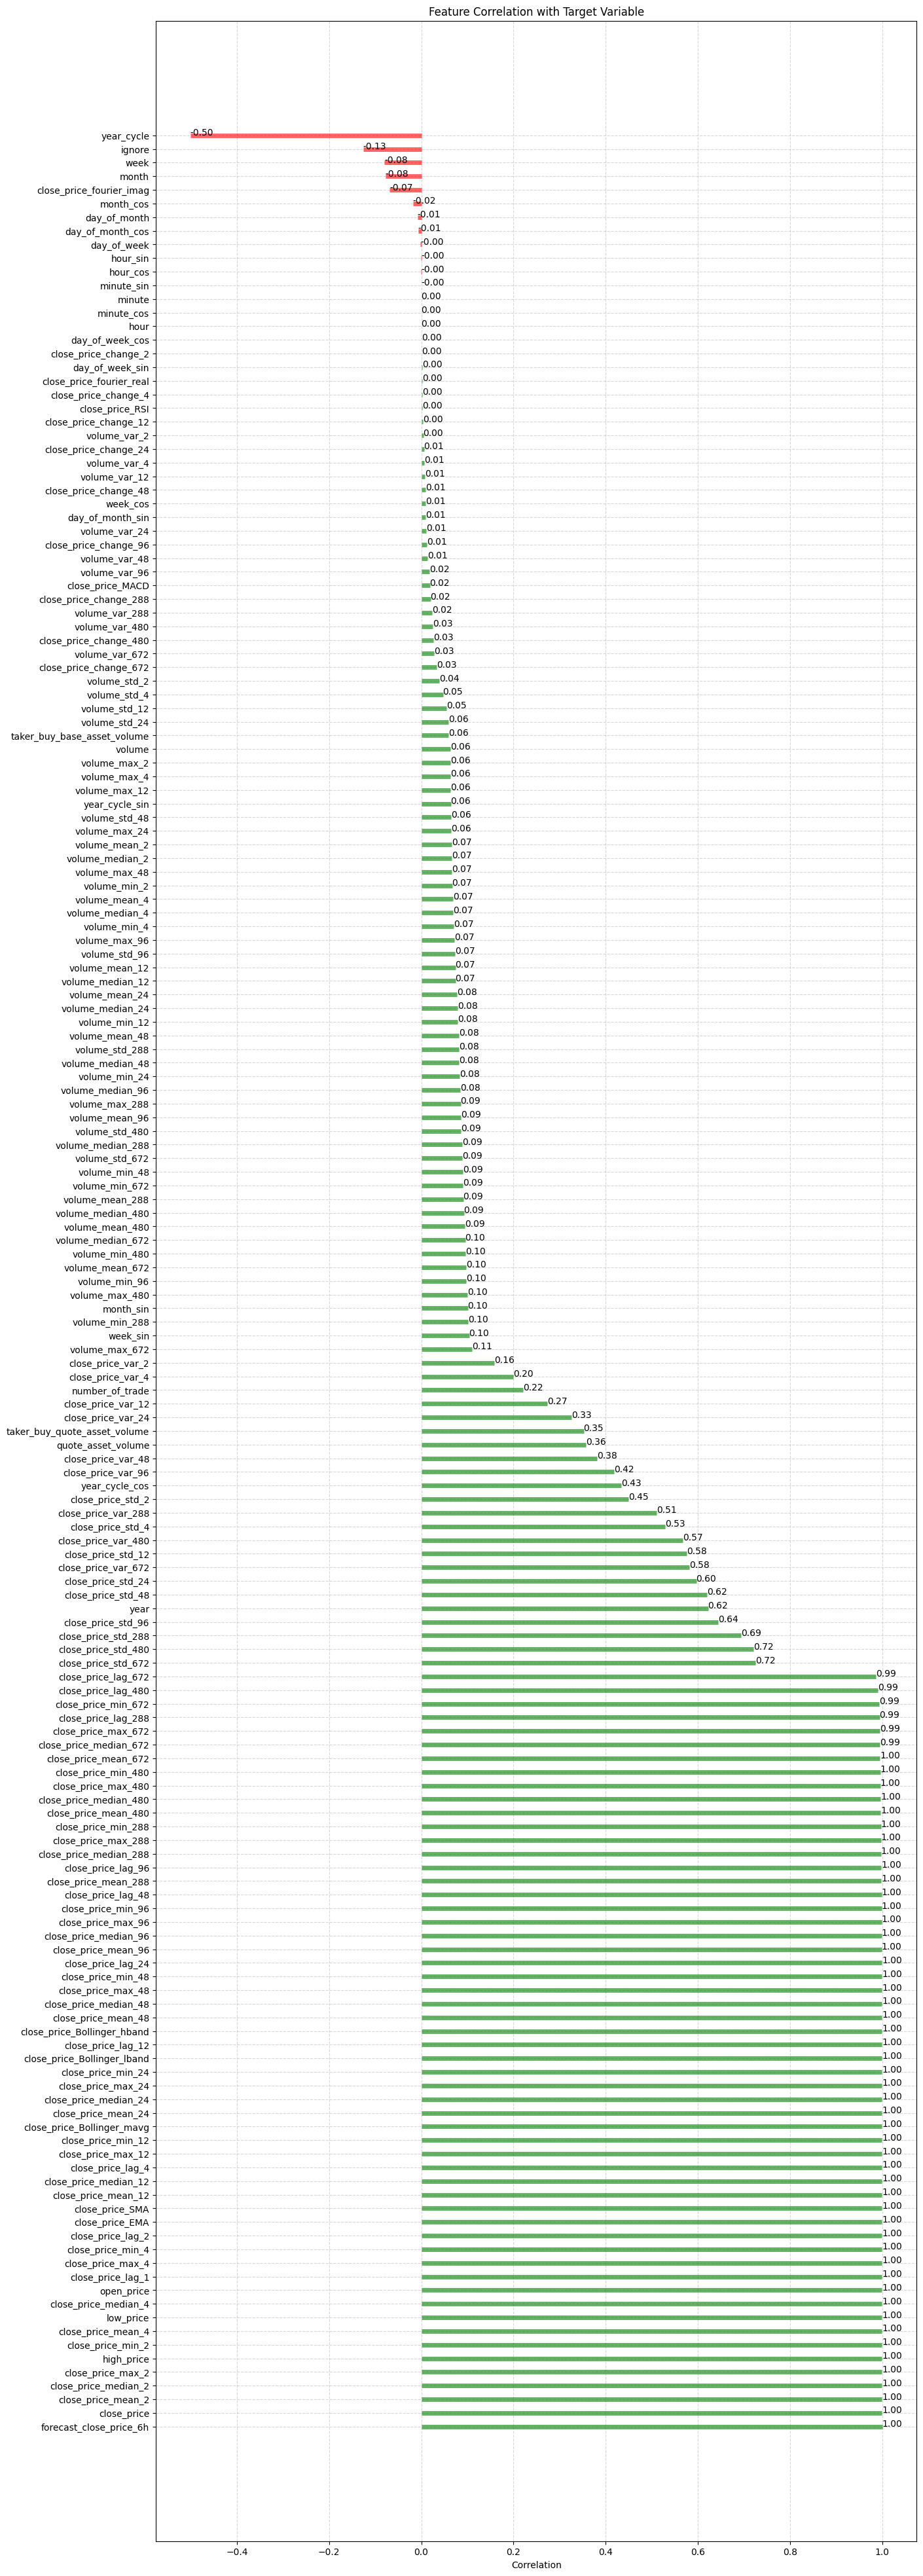

In [6]:
# Calculate the correlation matrix
target_correlation_matrix = df_feature_selection.corr()['forecast_close_price_6h'].sort_values(ascending=False)

# Construct data for horizontal gauge chart
target_correlation_matrix_dict = target_correlation_matrix.to_dict()
features = target_correlation_matrix_dict.keys()
correlations = target_correlation_matrix_dict.values()
colors = ['red' if x < 0 else 'green' for x in correlations]

# Create the horizontal gauge chart
plt.figure(figsize=(15, 50))
plt.hlines(y=features, xmin=0, xmax=correlations, color=colors, alpha=0.6, linewidth=5)

# Add data labels
for index, value in enumerate(correlations):
    plt.text(value, index, f'{value:.2f}')

# Set labels, title, and grid
plt.xlabel('Correlation')
plt.title('Feature Correlation with Target Variable')
plt.grid(linestyle='--', alpha=0.5)

# Show the plot
plt.show()

## 4.2 Lagged features selection based on Autocorrelation and Partial Autocorrelation

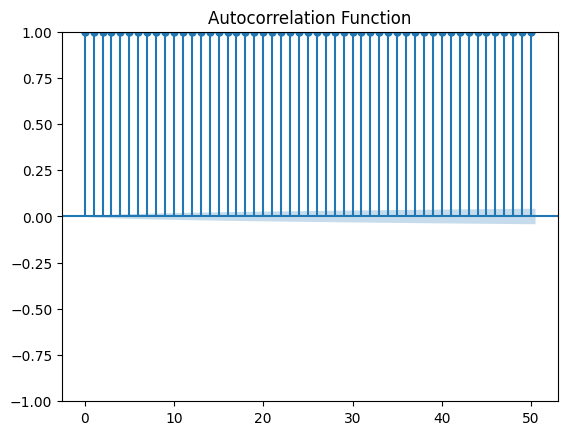

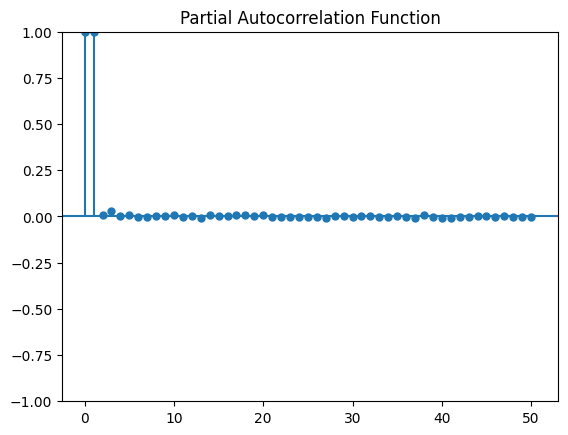

In [57]:
# Plotting ACF
plot_acf(df_feature_selection['close_price'], lags=50)
plt.title('Autocorrelation Function')
plt.show()

# Plotting PACF
plot_pacf(df_feature_selection['close_price'], lags=50)
plt.title('Partial Autocorrelation Function')
plt.show()

## 4.3 Find correlation and multicollinearity between features
**Action**: If 2 features have correlation, we might consider dropping one or combining them into a new feature.

### 4.3.1 All features

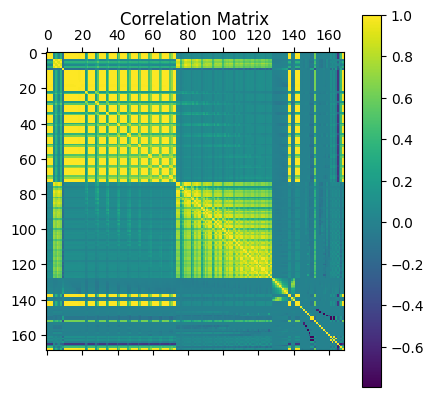

In [55]:
# Compute correlation matrix
correlation_matrix = df_feature_selection.corr()
plt.matshow(correlation_matrix)
plt.colorbar()
plt.title('Correlation Matrix', pad=20)
plt.show()

/Users/thakorns/Desktop/Eyp/codebases/stock-price-prediction/env/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/thakorns/Desktop/Eyp/codebases/stock-price-prediction/env/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 1000x1000 with 0 Axes>

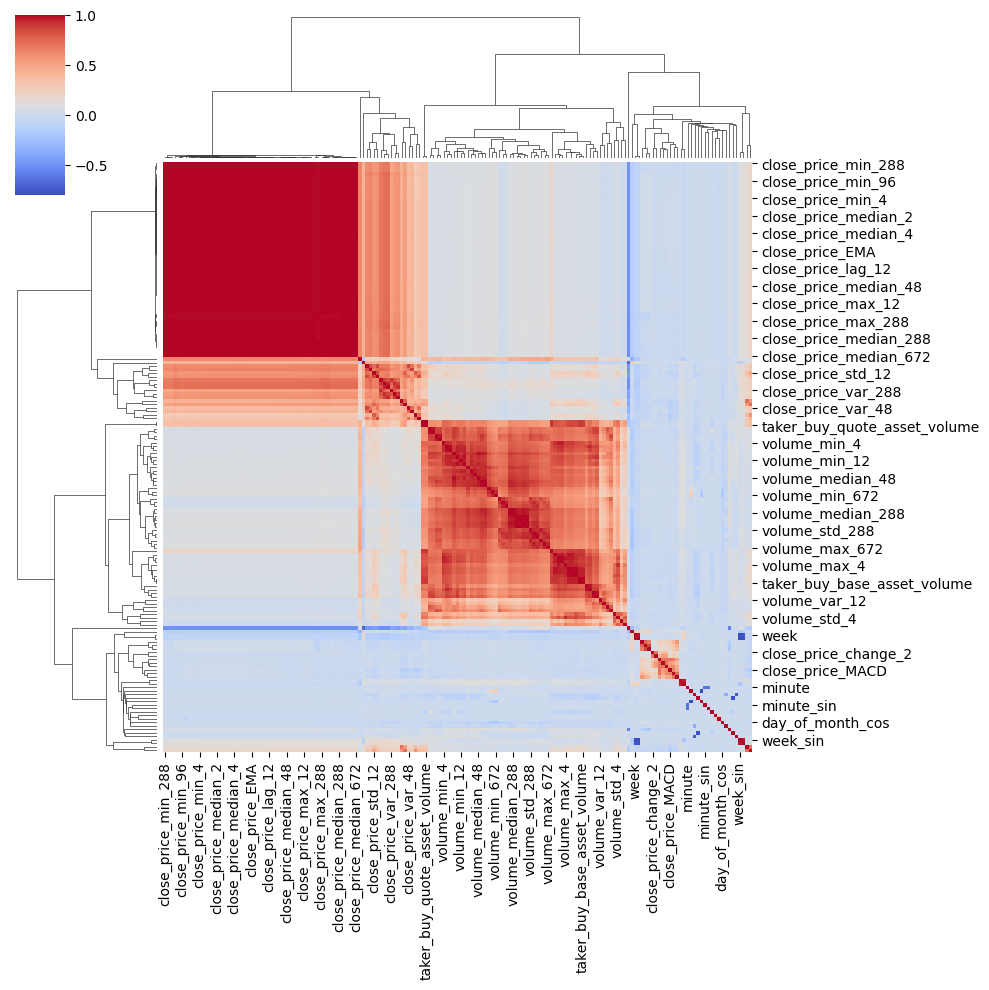

In [56]:
plt.figure(figsize=(10, 10))  # Size accordingly to your number of features

# Create a heatmap
# sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')

# Create a cluster map
sns.clustermap(correlation_matrix, figsize=(10, 10), cmap='coolwarm')

# Show the plot
plt.show()

### 4.3.2 Lagged features

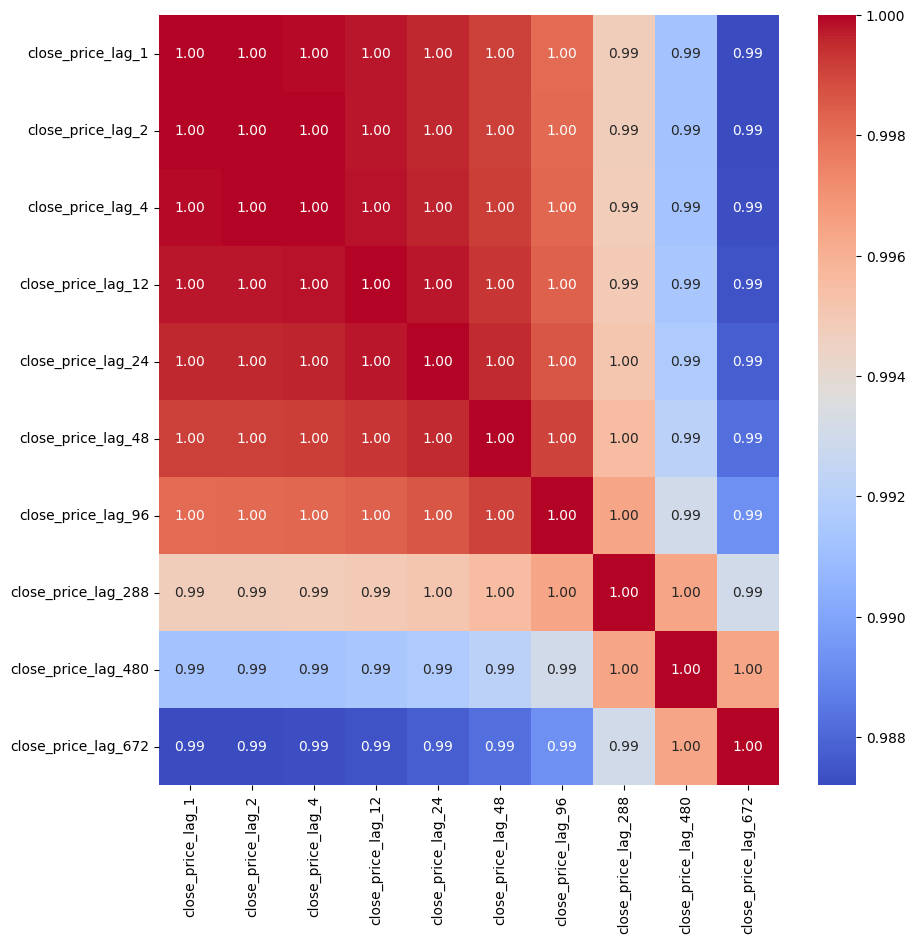

In [57]:
_column_names = sorted([col for col in df_feature_selection.columns if col.startswith('close_price_lag_')], key=lambda x: int(x.split('_')[-1]))
_correlation_matrix = df_feature_selection[_column_names].corr()

plt.figure(figsize=(10, 10))  # Size accordingly to your number of features
sns.heatmap(_correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
# sns.clustermap(_correlation_matrix, figsize=(10, 10), cmap='coolwarm')
plt.show()

### 4.3.3 Close price rolling window statistic

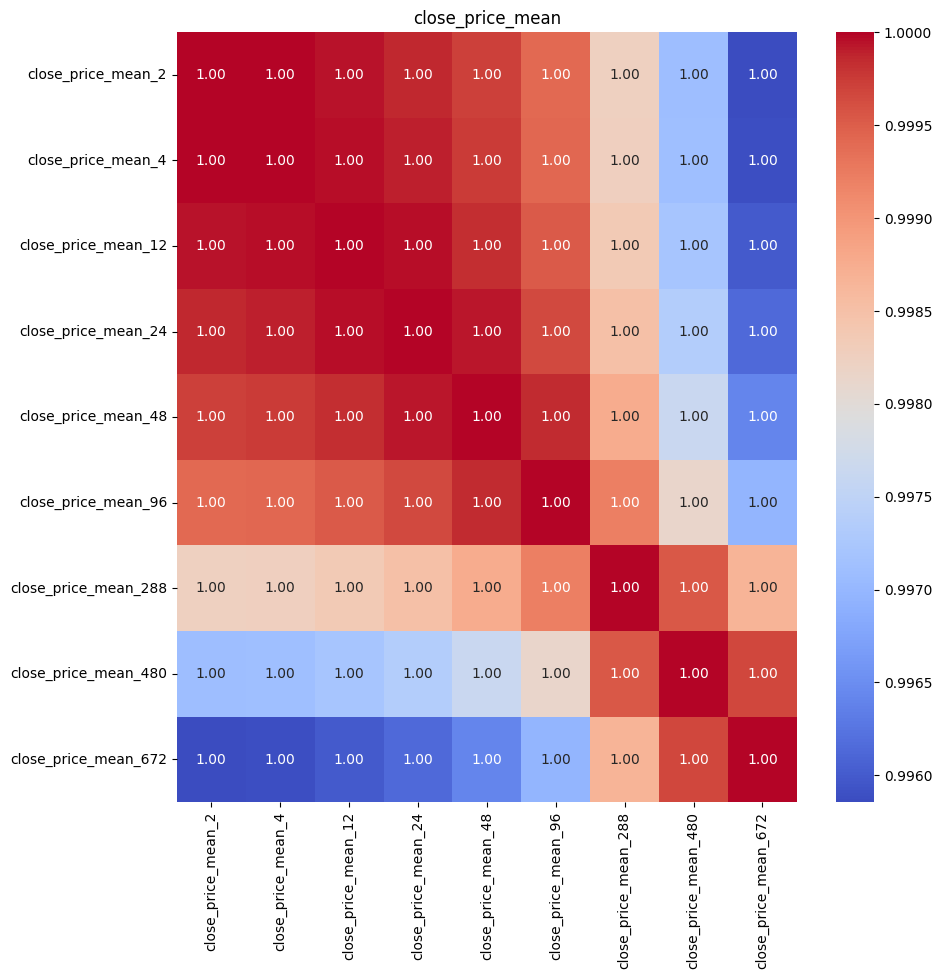

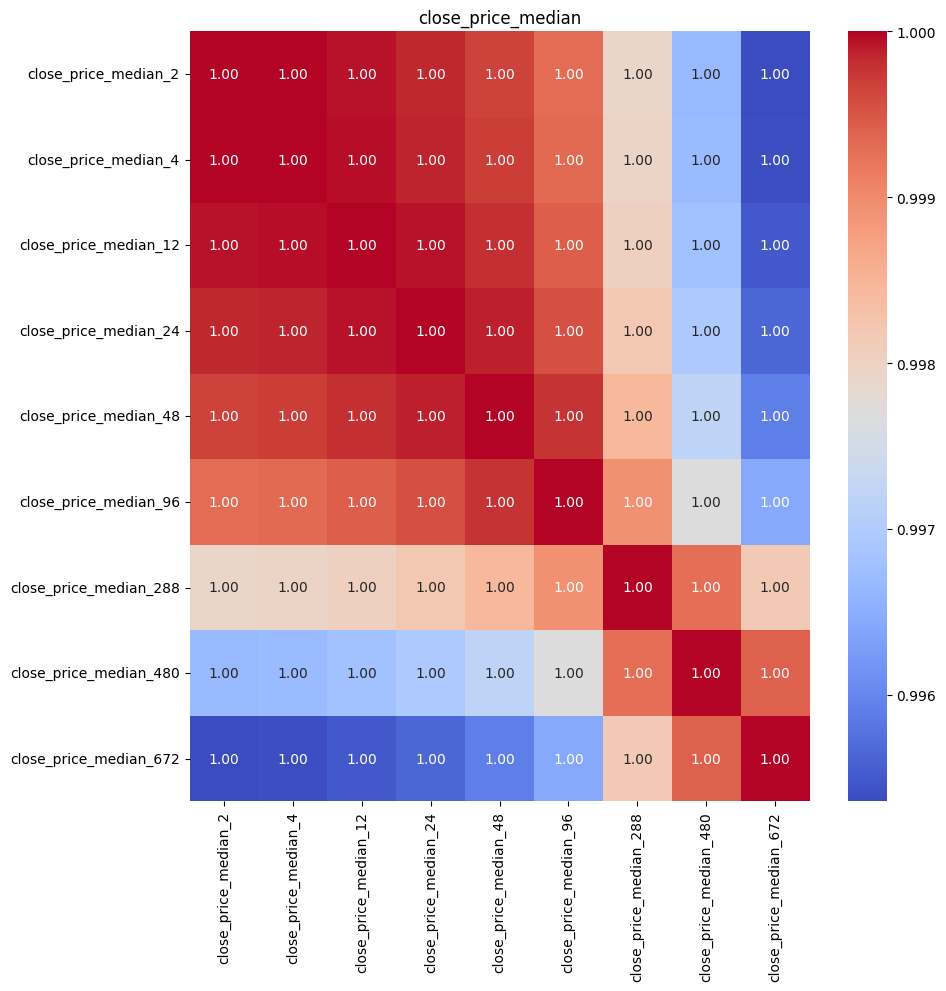

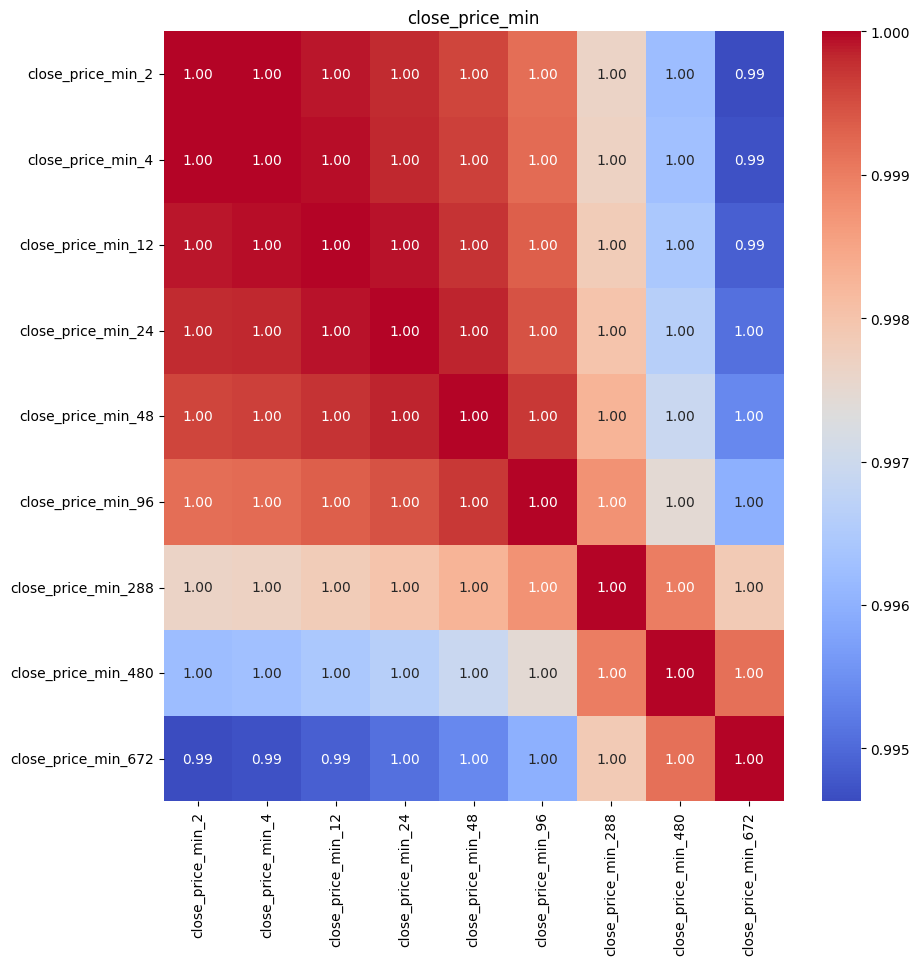

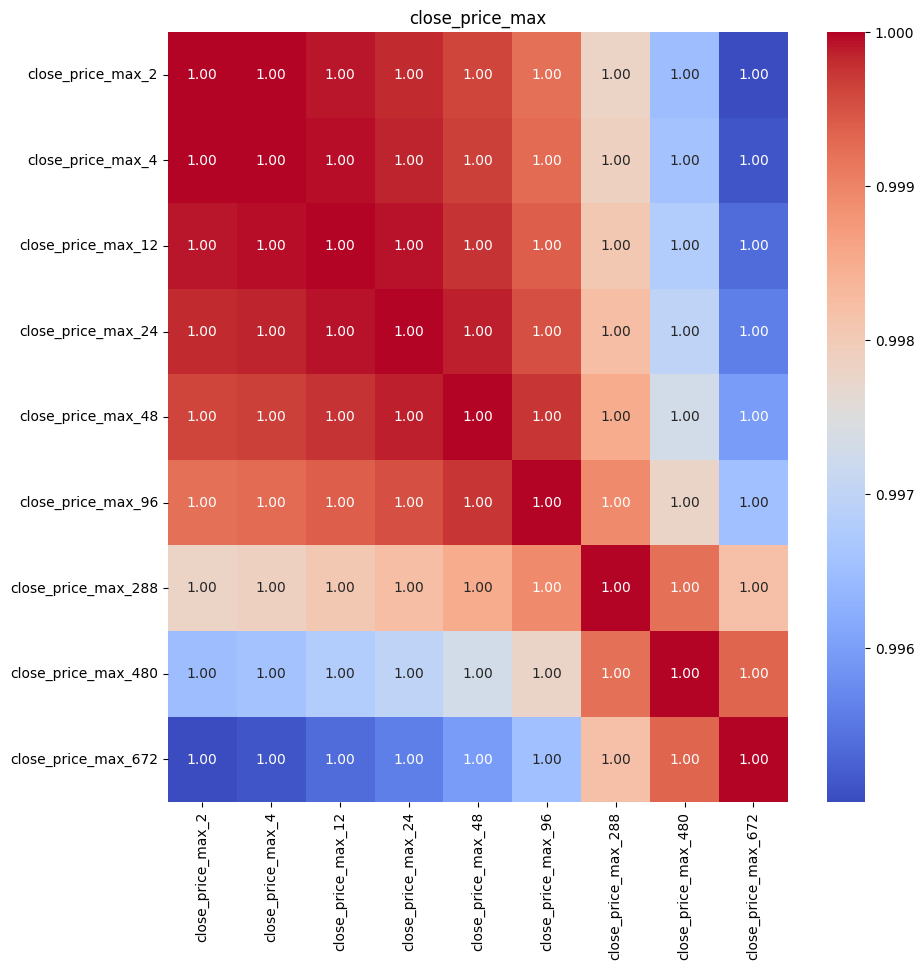

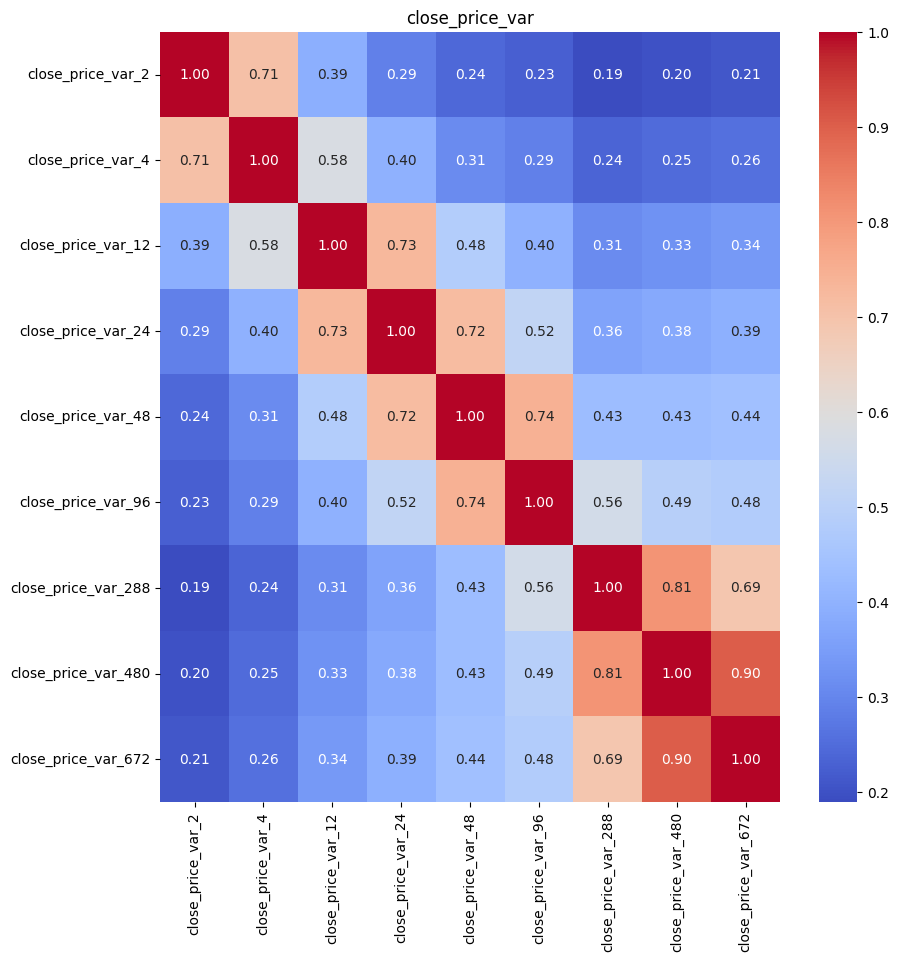

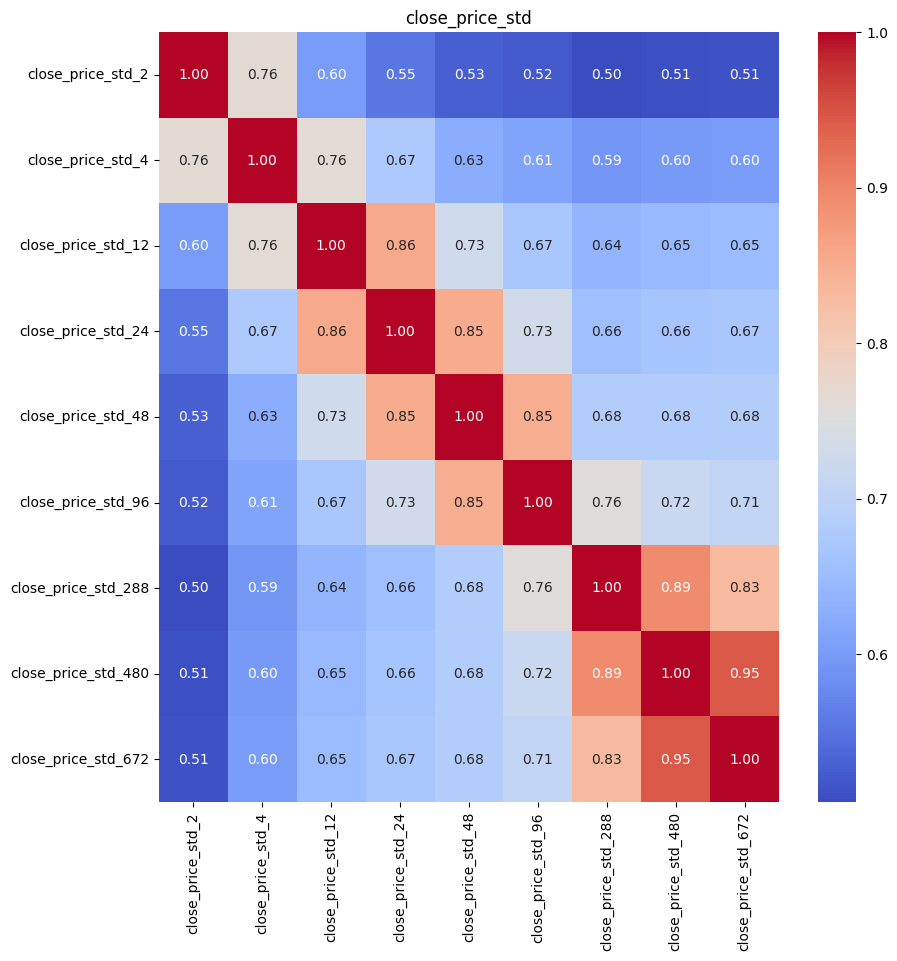

In [58]:
names = ['close_price_mean', 'close_price_median', 'close_price_min', 'close_price_max', 'close_price_var', 'close_price_std']

for name in names:
    _column_names = sorted([col for col in df_feature_selection.columns if col.startswith(name)], key=lambda x: int(x.split('_')[-1]))
    _correlation_matrix = df_feature_selection[_column_names].corr()

    plt.figure(figsize=(10, 10))  # Size accordingly to your number of features
    sns.heatmap(_correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
    # sns.clustermap(_correlation_matrix, figsize=(10, 10), cmap='coolwarm')
    
    # add plot title
    plt.title(name)
    plt.show()

<Figure size 1000x1000 with 0 Axes>

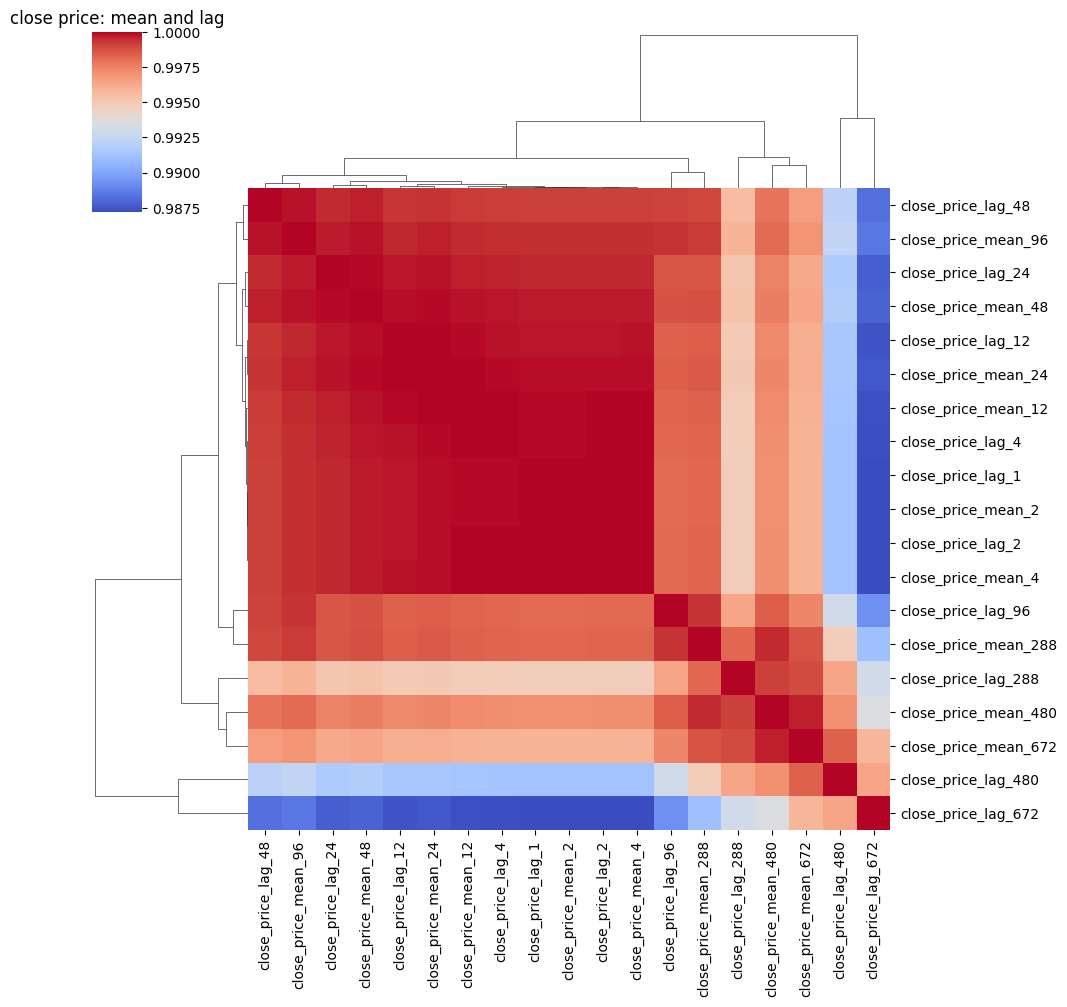

In [13]:
_column_names = sorted([col for col in df_feature_selection.columns if col.startswith('close_price_mean') or col.startswith('close_price_lag')], key=lambda x: int(x.split('_')[-1]))
_correlation_matrix = df_feature_selection[_column_names].corr()

plt.figure(figsize=(10, 10))  # Size accordingly to your number of features
# sns.heatmap(_correlation_matrix, annot=False, fmt=".2f", cmap='coolwarm')
sns.clustermap(_correlation_matrix, figsize=(10, 10), cmap='coolwarm')

# add plot title
plt.title('close price: mean and lag')
plt.show()

<Figure size 1000x1000 with 0 Axes>

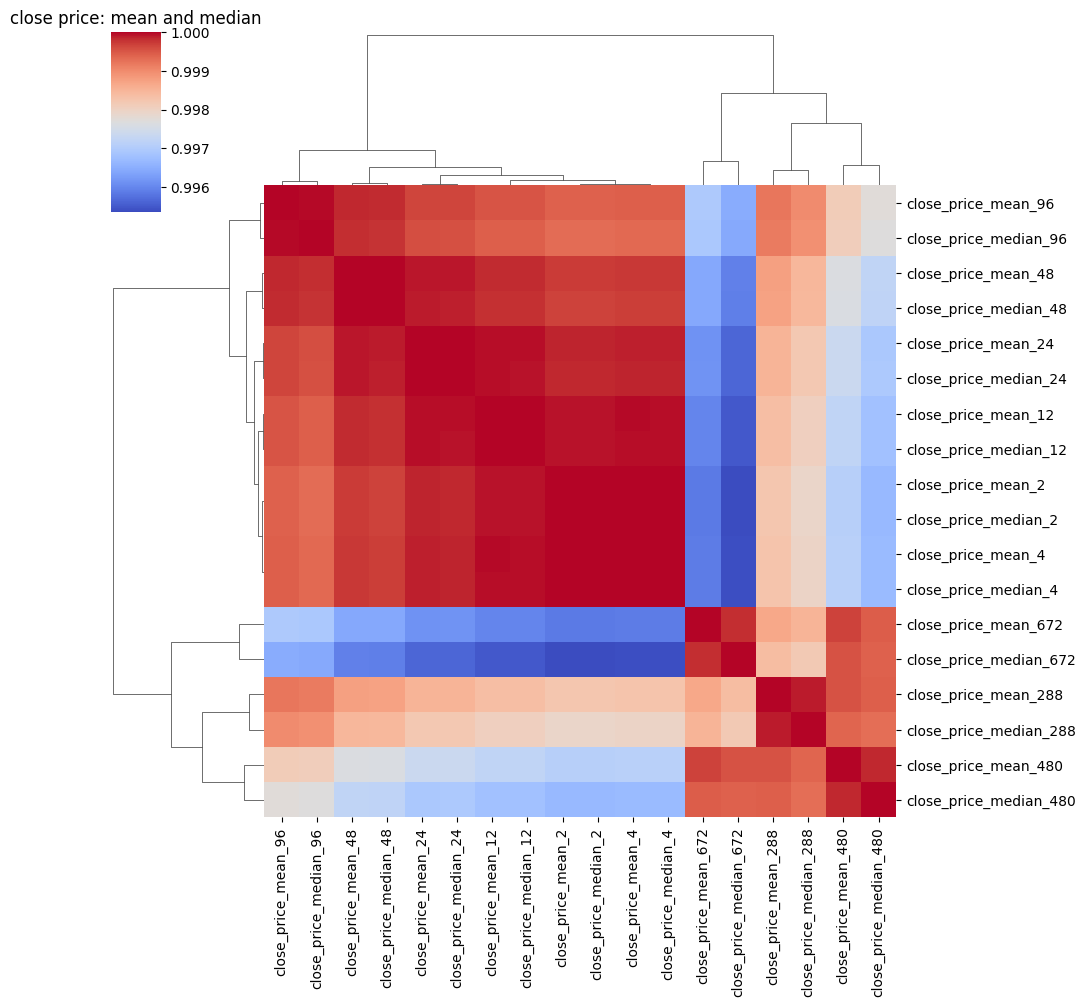

In [41]:
_column_names = sorted([col for col in df_feature_selection.columns if col.startswith('close_price_mean') or col.startswith('close_price_median')], key=lambda x: int(x.split('_')[-1]))
_correlation_matrix = df_feature_selection[_column_names].corr()

plt.figure(figsize=(10, 10))  # Size accordingly to your number of features
# sns.heatmap(_correlation_matrix, annot=False, fmt=".2f", cmap='coolwarm')
sns.clustermap(_correlation_matrix, figsize=(10, 10), cmap='coolwarm')

# add plot title
plt.title('close price: mean and median')
plt.show()

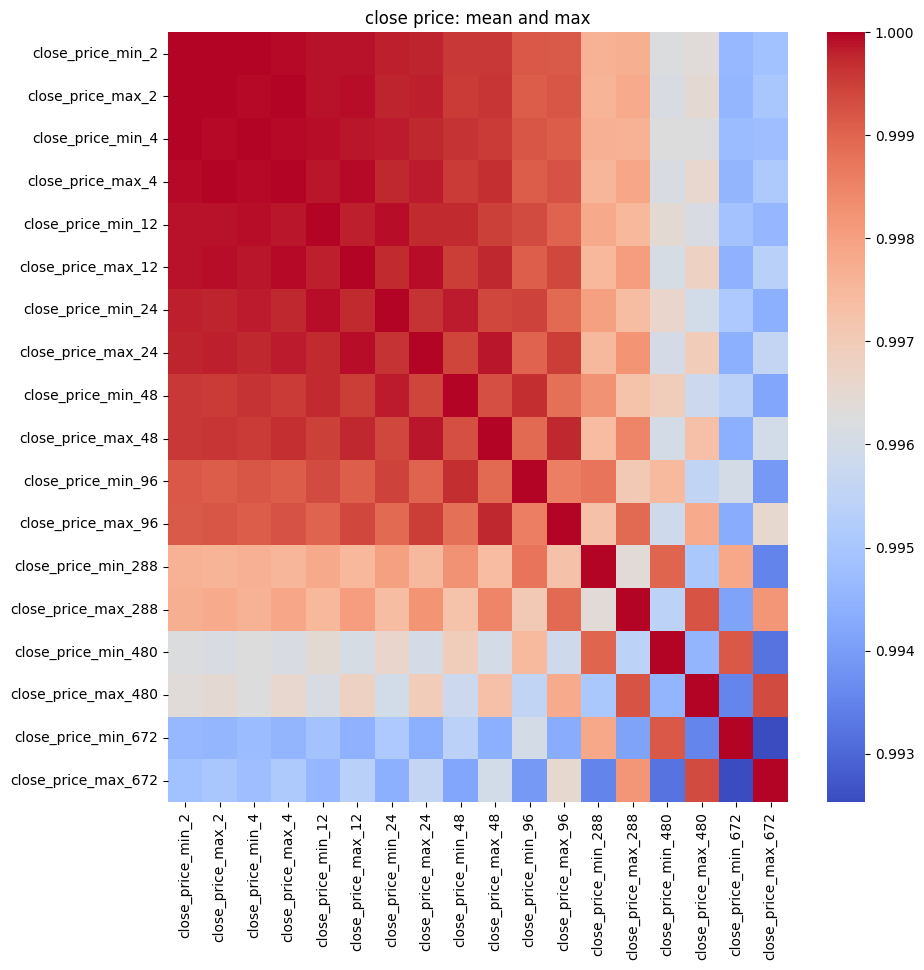

In [43]:
_column_names = sorted([col for col in df_feature_selection.columns if col.startswith('close_price_min') or col.startswith('close_price_max')], key=lambda x: int(x.split('_')[-1]))
_correlation_matrix = df_feature_selection[_column_names].corr()

plt.figure(figsize=(10, 10))  # Size accordingly to your number of features
sns.heatmap(_correlation_matrix, annot=False, fmt=".2f", cmap='coolwarm')
# sns.clustermap(_correlation_matrix, figsize=(10, 10), cmap='coolwarm')

# add plot title
plt.title('close price: mean and max')
plt.show()

### 4.3.4 Close price change

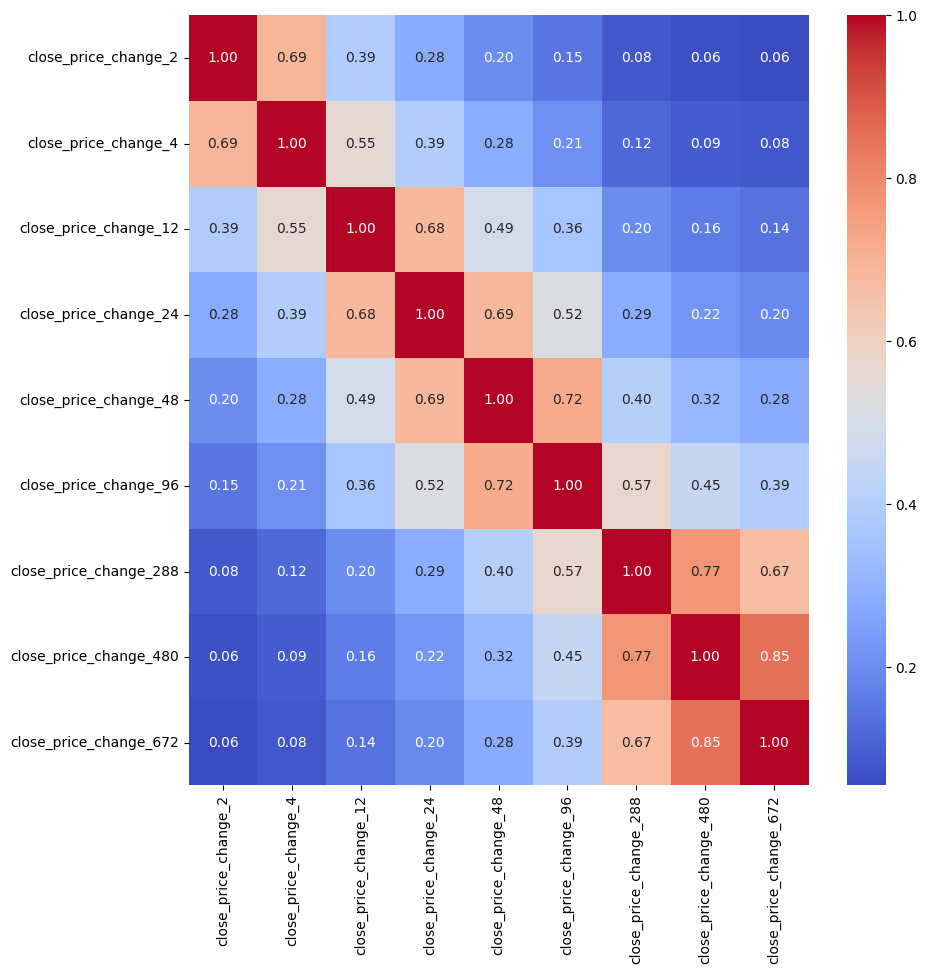

In [59]:
_column_names = sorted([col for col in df_feature_selection.columns if col.startswith('close_price_change_')], key=lambda x: int(x.split('_')[-1]))
_correlation_matrix = df_feature_selection[_column_names].corr()

plt.figure(figsize=(10, 10))  # Size accordingly to your number of features
sns.heatmap(_correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
# sns.clustermap(_correlation_matrix, figsize=(10, 10), cmap='coolwarm')
plt.show()

### 4.3.5 Volume rolling window statistic

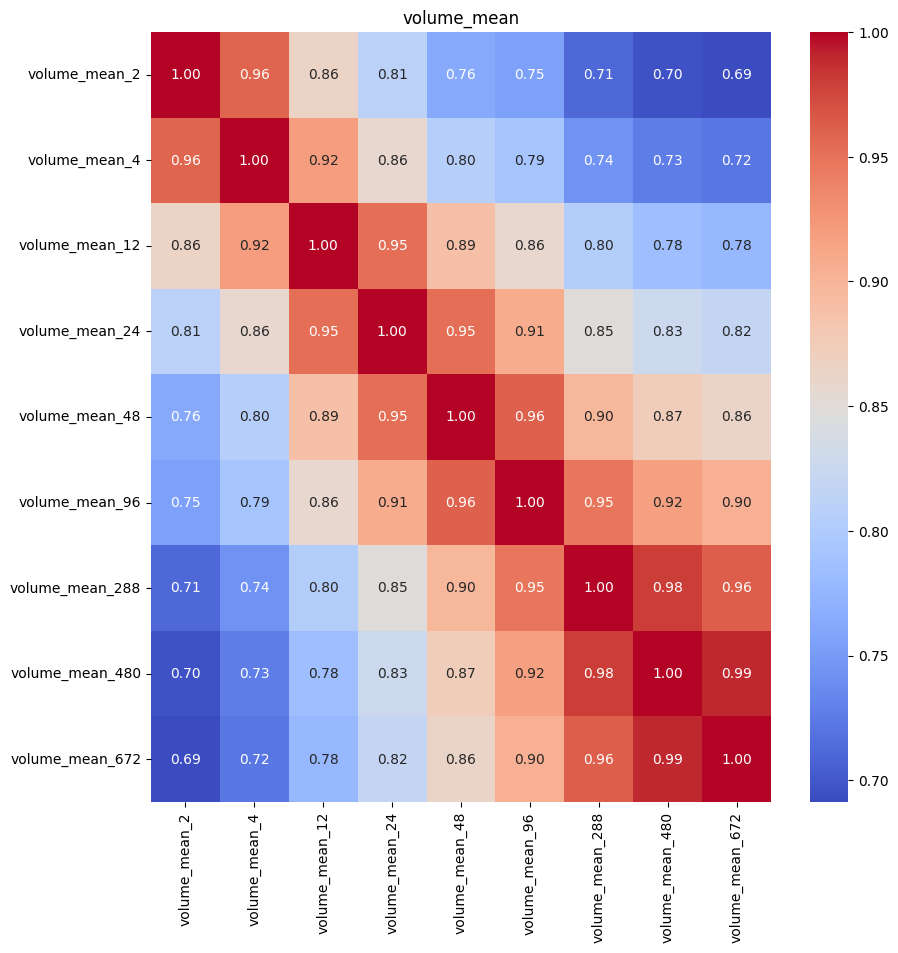

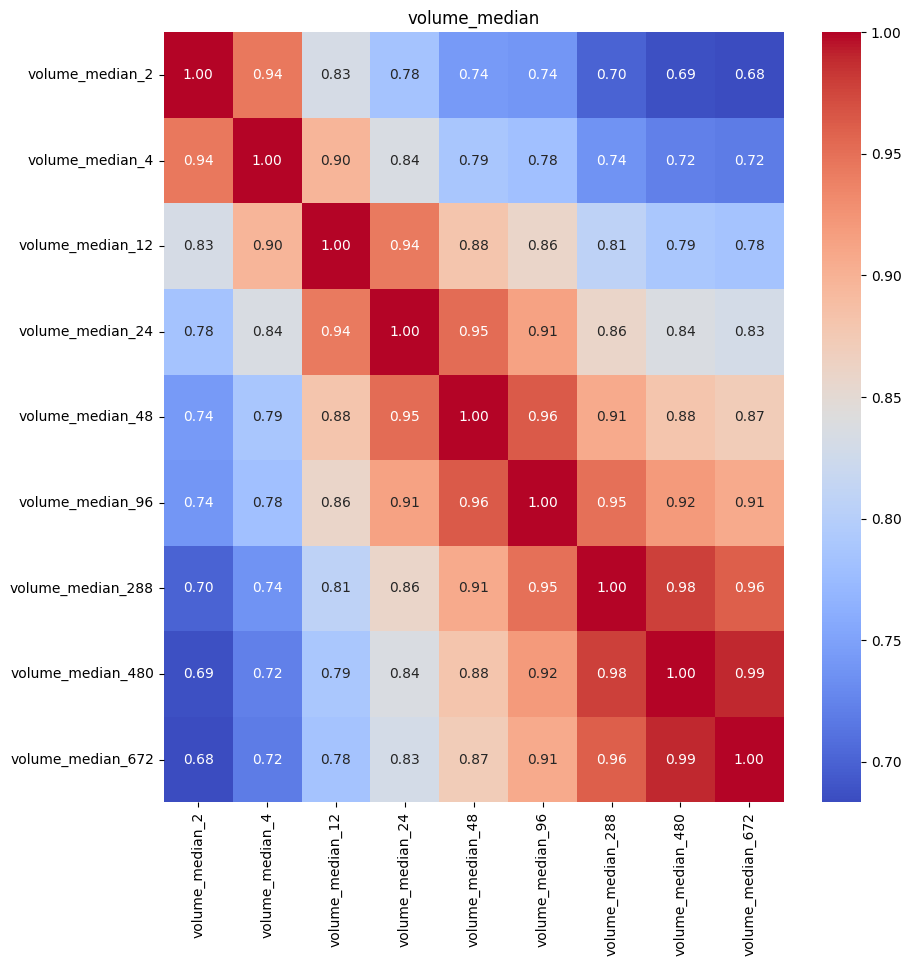

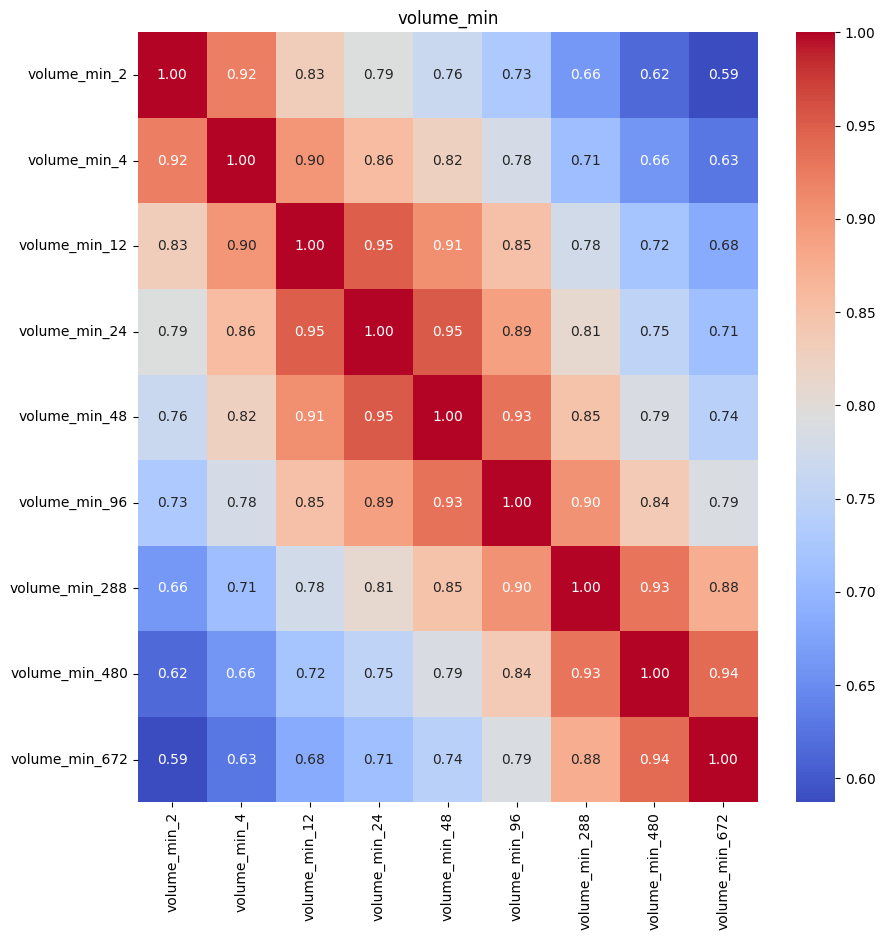

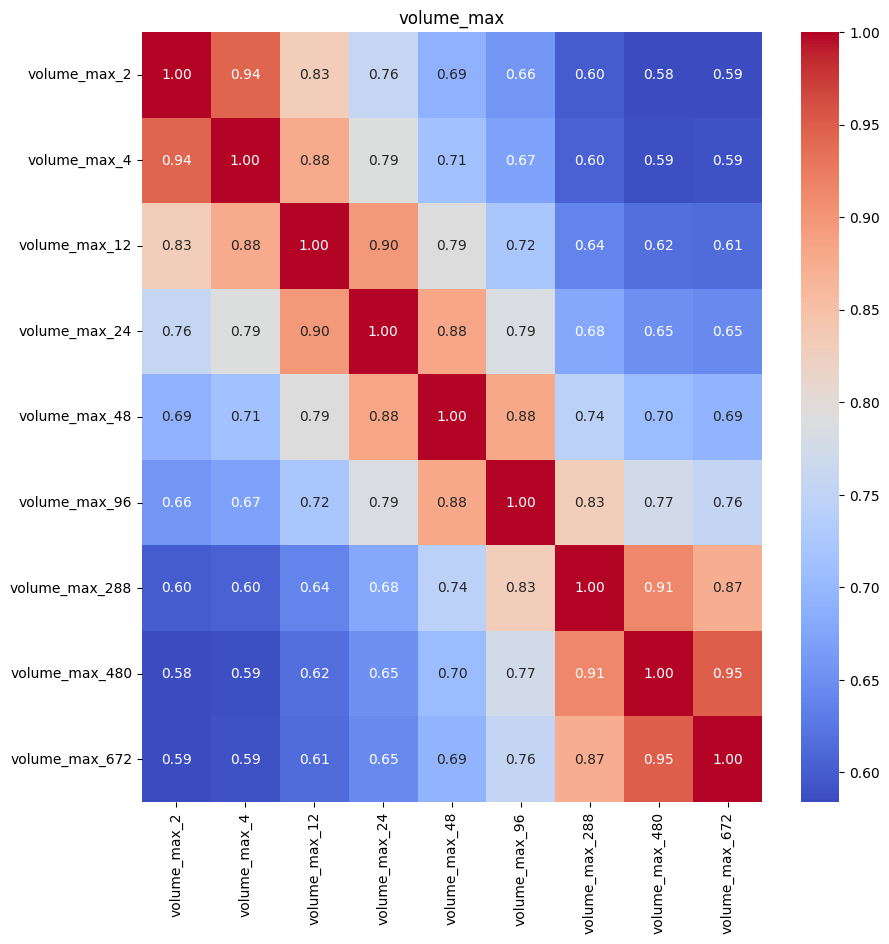

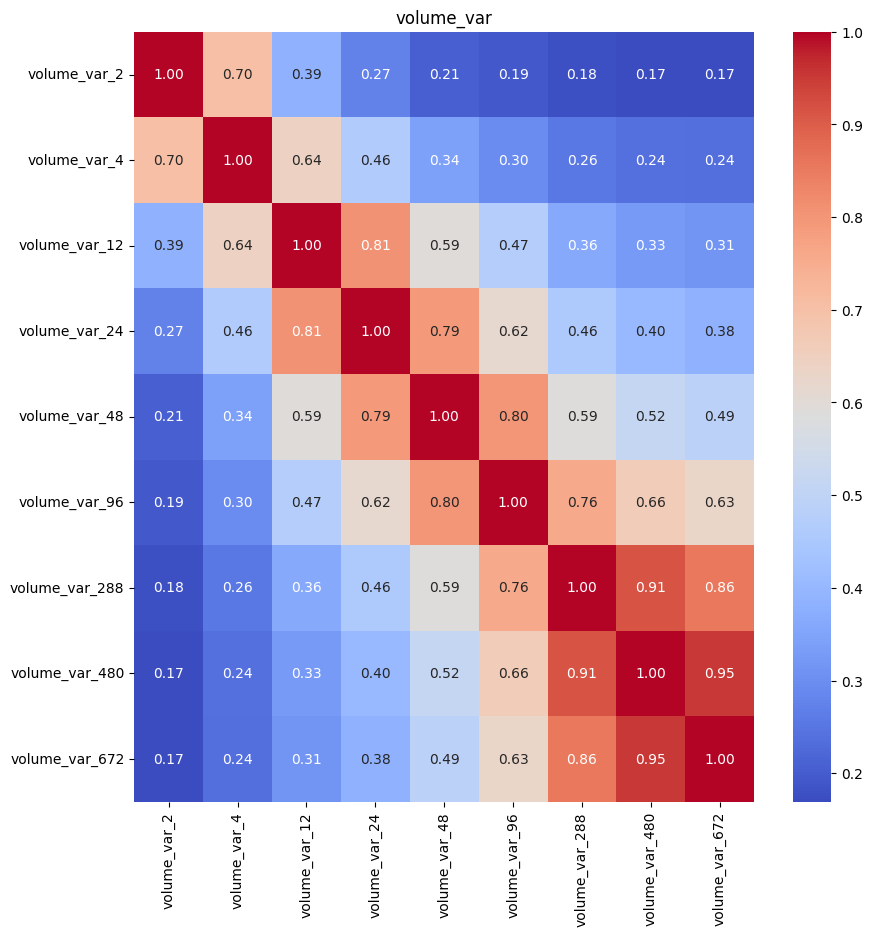

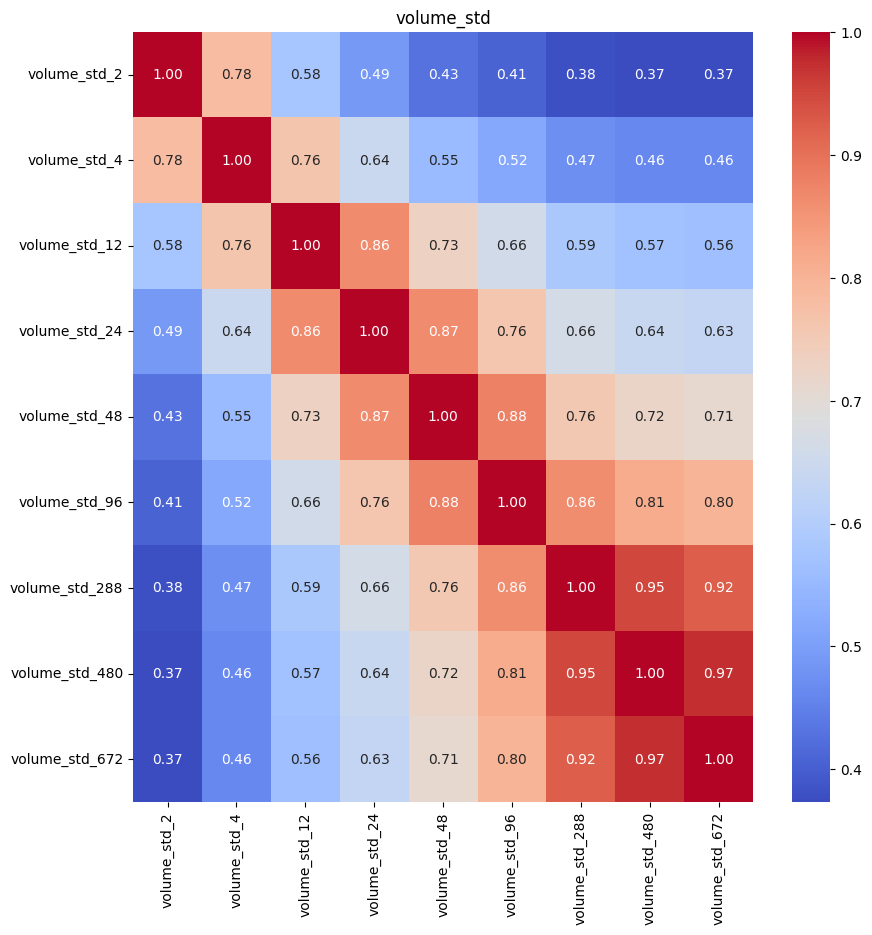

In [60]:
names = ['volume_mean', 'volume_median', 'volume_min', 'volume_max', 'volume_var', 'volume_std']

for name in names:
    _column_names = sorted([col for col in df_feature_selection.columns if col.startswith(name)], key=lambda x: int(x.split('_')[-1]))
    _correlation_matrix = df_feature_selection[_column_names].corr()

    plt.figure(figsize=(10, 10))  # Size accordingly to your number of features
    sns.heatmap(_correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
    # sns.clustermap(_correlation_matrix, figsize=(10, 10), cmap='coolwarm')
    
    # add plot title
    plt.title(name)
    plt.show()

<Figure size 1000x1000 with 0 Axes>

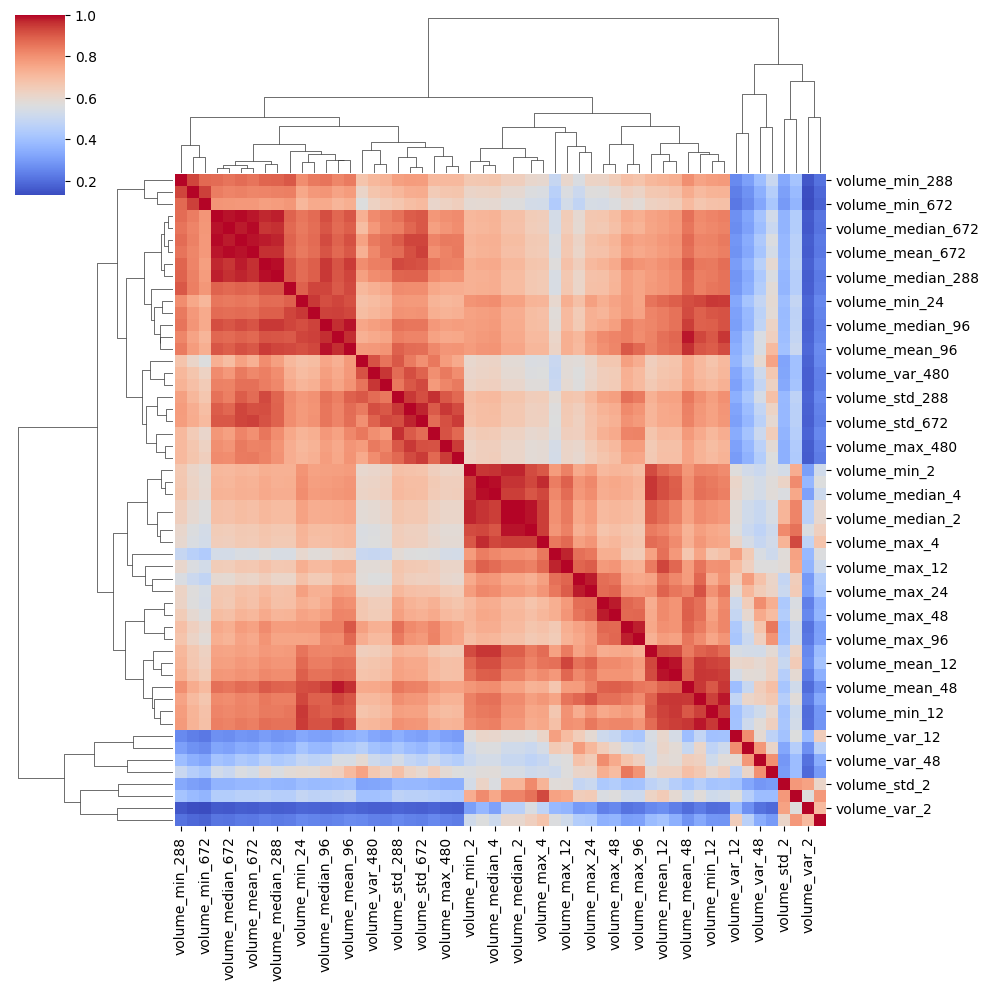

In [61]:
_column_names = sorted([col for col in df_feature_selection.columns if col.startswith('volume_')], key=lambda x: int(x.split('_')[-1]))
_correlation_matrix = df_feature_selection[_column_names].corr()

plt.figure(figsize=(10, 10))  # Size accordingly to your number of features
# sns.heatmap(_correlation_matrix, annot=False, fmt=".2f", cmap='coolwarm')
sns.clustermap(_correlation_matrix, figsize=(10, 10), cmap='coolwarm')
plt.show()

### 4.3.6 DateTime components

<Figure size 1000x1000 with 0 Axes>

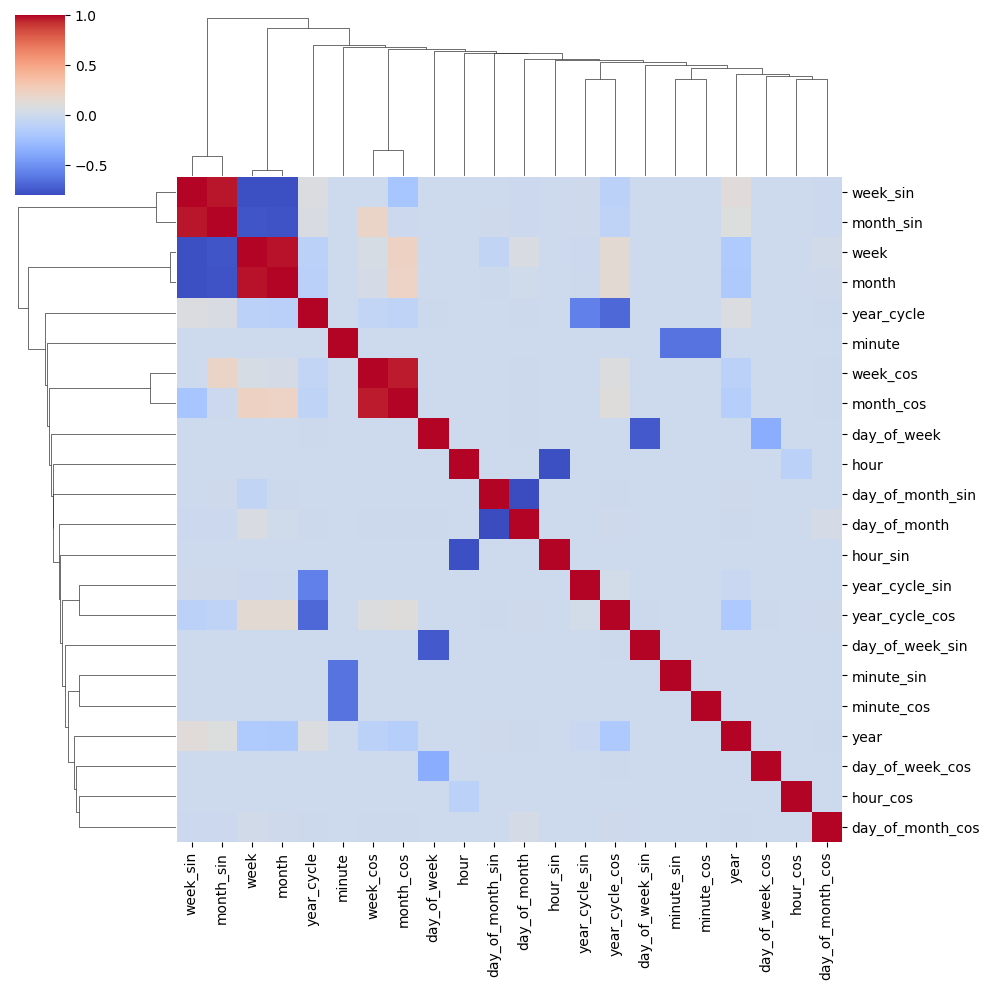

In [62]:
# all datetime-related components
_column_names = ['minute', 'hour', 'day_of_month', 'day_of_week', 'week', 'month', 'year', 'year_cycle', 'minute_sin', 'minute_cos', 'hour_sin', 'hour_cos', 'day_of_month_sin', 'day_of_month_cos', 'day_of_week_sin', 'day_of_week_cos', 'week_sin', 'week_cos', 'month_sin', 'month_cos', 'year_cycle_sin', 'year_cycle_cos']
_correlation_matrix = df_feature_selection[_column_names].corr()

plt.figure(figsize=(10, 10))  # Size accordingly to your number of features
# sns.heatmap(_correlation_matrix, annot=False, fmt=".2f", cmap='coolwarm')
sns.clustermap(_correlation_matrix, figsize=(10, 10), cmap='coolwarm')
plt.show()

## 4.4 Feature reduction based on correlation and multicollinearity between features

In [61]:
drop_columns = [
    # basic features (some got replaced by other processed features)
    'minute',
    'hour',
    'day_of_month',
    'day_of_week',
    'week',
    'month',
    'year',
    'open_price',
    'ignore',
    'year_cycle',

    # low correlation with target variable (`forecast_close_price_6h`)
    'minute_cos', 'minute_sin',
    'hour_cos', 'hour_sin',
    'day_of_month_cos', 'day_of_month_sin',
    'day_of_week_cos', 'day_of_week_sin',
    'close_price_fourier_real', 'close_price_fourier_imag',
    'close_price_change_2', 'close_price_change_4', 'close_price_change_12', 'close_price_change_24', 'close_price_change_48', 'close_price_change_96', 'close_price_change_288', 'close_price_change_480', 'close_price_change_672',
    
    # TODO: verify the lagging features using other method
    # lagged feature selection with autocorrelation and partial autocorrelation
    # 'close_price_lag_1', 'close_price_lag_2', 'close_price_lag_4', 'close_price_lag_12', 'close_price_lag_24', 'close_price_lag_48', 'close_price_lag_96', 'close_price_lag_288', 'close_price_lag_480', 'close_price_lag_672',
    
    # multicollinearity between features
    ## close price has high correlation within small window size, some also correlated with lagged features
    'close_price_mean_2', 'close_price_mean_4', 'close_price_mean_12', 'close_price_mean_48',
    'close_price_min_2', 'close_price_min_4', 'close_price_min_12', 'close_price_min_48',
    'close_price_max_2', 'close_price_max_4', 'close_price_max_12', 'close_price_max_48',
    ## volume has high correlation with adjacent window size, remove some of them
    'volume_mean_2', 'volume_mean_4', 'volume_mean_24', 'volume_mean_96', 'volume_mean_480',
    'volume_max_2', 'volume_max_4', 'volume_max_24', 'volume_max_96', 'volume_max_480',
    'volume_min_2', 'volume_min_4', 'volume_min_24', 'volume_min_96', 'volume_min_480',
    
    # remove redundant features (mean vs. median, var vs. std)
    ## close price
    'close_price_median_2', 'close_price_median_4', 'close_price_median_12', 'close_price_median_24', 'close_price_median_48', 'close_price_median_96', 'close_price_median_288', 'close_price_median_480', 'close_price_median_672',
    'close_price_var_2', 'close_price_var_4', 'close_price_var_12', 'close_price_var_24', 'close_price_var_48', 'close_price_var_96', 'close_price_var_288', 'close_price_var_480', 'close_price_var_672',
    ## volume
    'volume_median_2', 'volume_median_4', 'volume_median_12', 'volume_median_24', 'volume_median_48', 'volume_median_96', 'volume_median_288', 'volume_median_480', 'volume_median_672',
    'volume_var_2', 'volume_var_4', 'volume_var_12', 'volume_var_24', 'volume_var_48', 'volume_var_96', 'volume_var_288', 'volume_var_480', 'volume_var_672',
    
    # sincos transformation of week and month are quite correlated with each other, remove one of them
    'month_cos', 'month_sin',
]

# read the feature extracted data from CSV file
df_feature_selection_v1 = pd.read_csv('dataset/feature_extracted_data.csv', index_col='open_time')

# select target feature as the next 6-hour close price and filter-out the last 24 rows of data
df_feature_selection_v1['forecast_close_price_6h'] = df_feature_selection_v1['close_price'].shift(-24)
df_feature_selection_v1 = df_feature_selection_v1.iloc[:-24]

# drop columns
df_feature_selection_v1 = df_feature_selection_v1.drop(drop_columns, axis=1)

In [62]:
df_feature_selection_v1

high_price  low_price  close_price      volume  \
open_time                                                             
2017-08-24 04:15:00     4146.07    4100.04      4112.49    9.992209   
2017-08-24 04:30:00     4139.88    4090.39      4090.39    9.169979   
2017-08-24 04:45:00     4129.00    4107.44      4113.98    5.594383   
2017-08-24 05:00:00     4146.53    4113.49      4140.76    6.614522   
2017-08-24 05:15:00     4146.53    4113.49      4128.82    9.574157   
...                         ...        ...          ...         ...   
2023-10-31 16:45:00    34480.00   34402.00     34425.60  405.132920   
2023-10-31 17:00:00    34430.00   34350.00     34369.11  272.112860   
2023-10-31 17:15:00    34412.15   34352.70     34389.99  247.082520   
2023-10-31 17:30:00    34390.00   34355.38     34376.24  159.966610   
2023-10-31 17:45:00    34394.70   34355.38     34381.03  138.210360   

                     quote_asset_volume  number_of_trade  \
open_time                                                  
2017-08-24 04:15:00        4.108641e+04             55.0   
2017-08-24 04:30:00        3.775046e+04             51.0   
2017-08-24 04:45:00        2.302416e+04             47.0   
2017-08-24 05:00:00        2.729685e+04             55.0   
2017-08-24 05:15:00        3.957526e+04             60.0   
...                                 ...              ...   
2023-10-31 16:45:00        1.395058e+07          15125.0   
2023-10-31 17:00:00        9.357920e+06          11488.0   
2023-10-31 17:15:00        8.496576e+06          10314.0   
2023-10-31 17:30:00        5.499119e+06           6546.0   
2023-10-31 17:45:00        4.751046e+06           7665.0   

                     taker_buy_base_asset_volume  \
open_time                                          
2017-08-24 04:15:00                     0.912606   
2017-08-24 04:30:00                     1.187220   
2017-08-24 04:45:00                     0.545128   
2017-08-24 05:00:00                     3.258082   
2017-08-24 05:15:00                     1.214894   
...                                          ...   
2023-10-31 16:45:00                   199.333050   
2023-10-31 17:00:00                   110.505520   
2023-10-31 17:15:00                   117.512960   
2023-10-31 17:30:00                    71.625960   
2023-10-31 17:45:00                    63.112090   

                     taker_buy_quote_asset_volume  close_price_lag_1  \
open_time                                                              
2017-08-24 04:15:00                  3.782746e+03            4100.06   
2017-08-24 04:30:00                  4.906594e+03            4112.49   
2017-08-24 04:45:00                  2.250812e+03            4090.39   
2017-08-24 05:00:00                  1.348110e+04            4113.98   
2017-08-24 05:15:00                  5.033432e+03            4140.76   
...                                           ...                ...   
2023-10-31 16:45:00                  6.863906e+06           34459.87   
2023-10-31 17:00:00                  3.799915e+06           34425.60   
2023-10-31 17:15:00                  4.040973e+06           34369.11   
2023-10-31 17:30:00                  2.462078e+06           34389.99   
2023-10-31 17:45:00                  2.169369e+06           34376.24   

                     close_price_lag_2  ...  close_price_MACD  \
open_time                               ...                     
2017-08-24 04:15:00            4113.58  ...         -6.733029   
2017-08-24 04:30:00            4100.06  ...         -9.065306   
2017-08-24 04:45:00            4112.49  ...         -8.907456   
2017-08-24 05:00:00            4090.39  ...         -6.545979   
2017-08-24 05:15:00            4113.98  ...         -5.573700   
...                                ...  ...               ...   
2023-10-31 16:45:00           34342.20  ...          3.595981   
2023-10-31 17:00:00           34459.87  ...          6.390200   
2023-10-31 17:15:00           34425.60  ...         

## 4.5 Feature reduction with Feature Importance from Tree-based Models
Tree-based models like Random Forests can be used to estimate the importance of features.

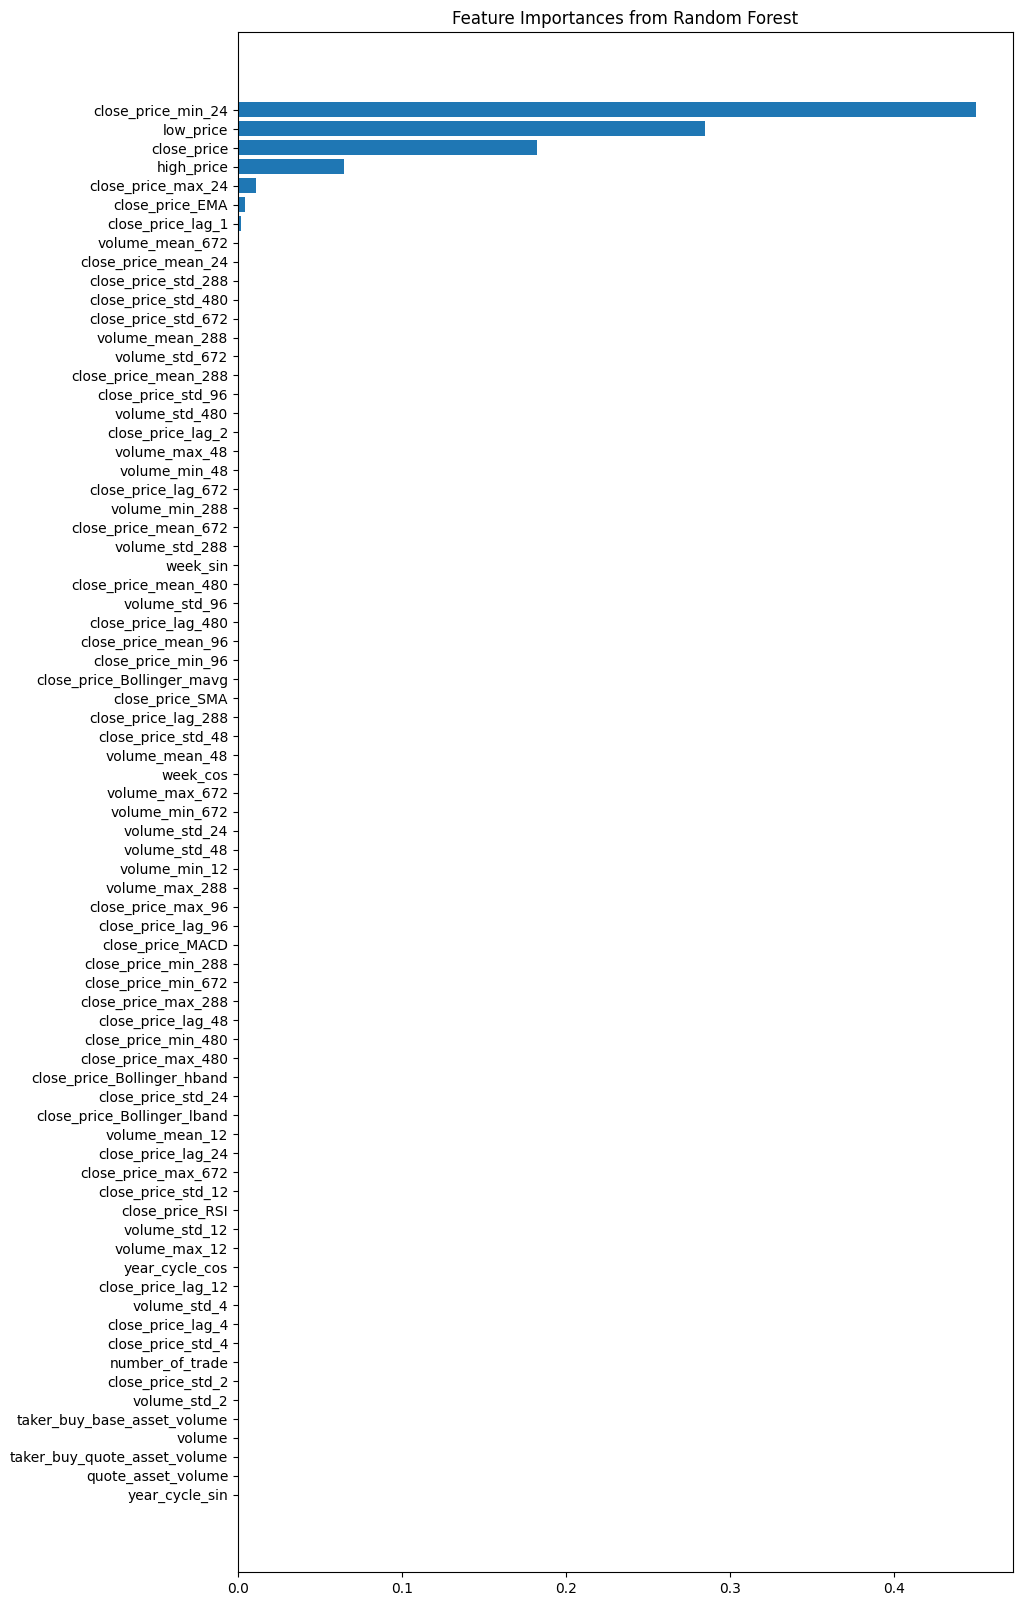

In [69]:
X = df_feature_selection_v1.drop(['forecast_close_price_6h'], axis=1)
y = df_feature_selection_v1['forecast_close_price_6h']

# Fit a RandomForestRegressor to get feature importance
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# Plot feature importance
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, 20))
plt.title('Feature Importances from Random Forest')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [df_feature_selection_v1.columns[i] for i in indices])
plt.show()

## 4.6 Feature reduction with Principal Component Analysis (PCA)
Reduced the dimensionality of the dataset by projecting it onto a lower-dimensional subspace.

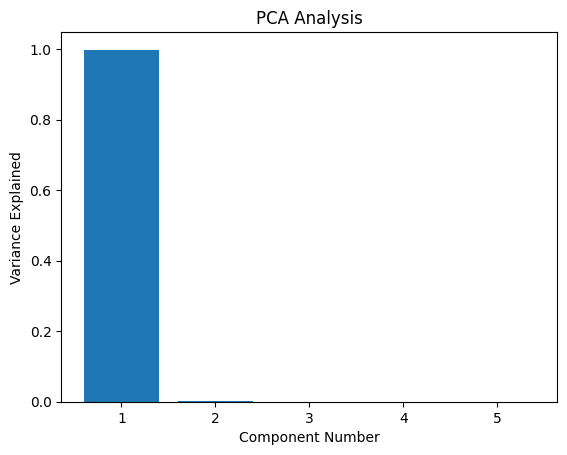

In [71]:
X = df_feature_selection_v1.drop(['forecast_close_price_6h'], axis=1)

# Apply PCA method
pca = PCA(n_components=5)  # reduce to X components
# `X_pca` can now be used in place of X for models that benefit from reduced dimensionality.
X_pca = pca.fit_transform(X)

# Plot variance explained by each component
plt.bar(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_)
plt.xlabel('Component Number')
plt.ylabel('Variance Explained')
plt.title('PCA Analysis')
plt.show()

## 4.7 Feature reduction with Recursive Feature Elimination (RFE)

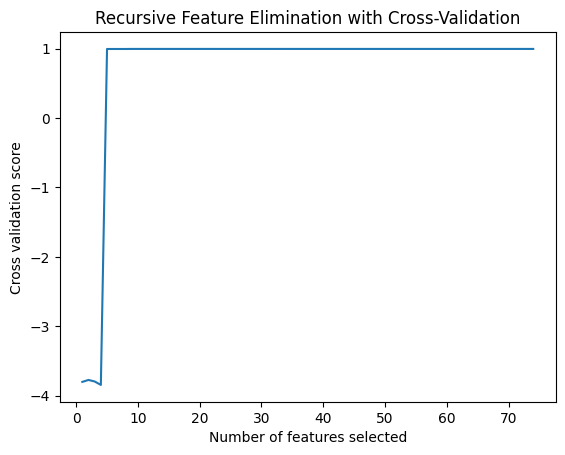

Selected Features: ['high_price' 'low_price' 'close_price' 'close_price_lag_1'
 'close_price_std_4' 'close_price_mean_24' 'close_price_std_24'
 'close_price_min_24' 'close_price_std_48' 'close_price_mean_96'
 'close_price_max_96' 'volume_min_288' 'volume_min_672' 'close_price_SMA'
 'close_price_EMA' 'close_price_MACD' 'close_price_RSI'
 'close_price_Bollinger_lband' 'week_sin' 'week_cos' 'year_cycle_sin']


In [73]:
X = df_feature_selection_v1.drop(['forecast_close_price_6h'], axis=1)
y = df_feature_selection_v1['forecast_close_price_6h']

# Apply RFE using a simple linear regression model
estimator = LinearRegression()
selector = RFECV(estimator, step=1, cv=5)
selector = selector.fit(X, y)

# Plot number of features vs. cross-validation scores
plt.figure()
plt.title('Recursive Feature Elimination with Cross-Validation')
plt.xlabel('Number of features selected')
plt.ylabel('Cross validation score')
plt.plot(range(1, len(selector.cv_results_['mean_test_score']) + 1), selector.cv_results_['mean_test_score'])
plt.show()

# Display the features that were selected
selected_features = np.array(X.columns)[selector.support_]
print("Selected Features:", selected_features)

# 5. Save final dataset

In [74]:
# save the selected feature data to CSV file
df_feature_selection_v1.to_csv('dataset/feature_selected_data.csv', index=True)

In [75]:
# test loading the selected feature data from CSV file
pd.read_csv('dataset/feature_selected_data.csv', index_col='open_time')

high_price  low_price  close_price      volume  \
open_time                                                             
2017-08-24 04:15:00     4146.07    4100.04      4112.49    9.992209   
2017-08-24 04:30:00     4139.88    4090.39      4090.39    9.169979   
2017-08-24 04:45:00     4129.00    4107.44      4113.98    5.594383   
2017-08-24 05:00:00     4146.53    4113.49      4140.76    6.614522   
2017-08-24 05:15:00     4146.53    4113.49      4128.82    9.574157   
...                         ...        ...          ...         ...   
2023-10-31 16:45:00    34480.00   34402.00     34425.60  405.132920   
2023-10-31 17:00:00    34430.00   34350.00     34369.11  272.112860   
2023-10-31 17:15:00    34412.15   34352.70     34389.99  247.082520   
2023-10-31 17:30:00    34390.00   34355.38     34376.24  159.966610   
2023-10-31 17:45:00    34394.70   34355.38     34381.03  138.210360   

                     quote_asset_volume  number_of_trade  \
open_time                                                  
2017-08-24 04:15:00        4.108641e+04             55.0   
2017-08-24 04:30:00        3.775046e+04             51.0   
2017-08-24 04:45:00        2.302416e+04             47.0   
2017-08-24 05:00:00        2.729685e+04             55.0   
2017-08-24 05:15:00        3.957526e+04             60.0   
...                                 ...              ...   
2023-10-31 16:45:00        1.395058e+07          15125.0   
2023-10-31 17:00:00        9.357920e+06          11488.0   
2023-10-31 17:15:00        8.496576e+06          10314.0   
2023-10-31 17:30:00        5.499119e+06           6546.0   
2023-10-31 17:45:00        4.751046e+06           7665.0   

                     taker_buy_base_asset_volume  \
open_time                                          
2017-08-24 04:15:00                     0.912606   
2017-08-24 04:30:00                     1.187220   
2017-08-24 04:45:00                     0.545128   
2017-08-24 05:00:00                     3.258082   
2017-08-24 05:15:00                     1.214894   
...                                          ...   
2023-10-31 16:45:00                   199.333050   
2023-10-31 17:00:00                   110.505520   
2023-10-31 17:15:00                   117.512960   
2023-10-31 17:30:00                    71.625960   
2023-10-31 17:45:00                    63.112090   

                     taker_buy_quote_asset_volume  close_price_lag_1  \
open_time                                                              
2017-08-24 04:15:00                  3.782746e+03            4100.06   
2017-08-24 04:30:00                  4.906594e+03            4112.49   
2017-08-24 04:45:00                  2.250812e+03            4090.39   
2017-08-24 05:00:00                  1.348110e+04            4113.98   
2017-08-24 05:15:00                  5.033432e+03            4140.76   
...                                           ...                ...   
2023-10-31 16:45:00                  6.863906e+06           34459.87   
2023-10-31 17:00:00                  3.799915e+06           34425.60   
2023-10-31 17:15:00                  4.040973e+06           34369.11   
2023-10-31 17:30:00                  2.462078e+06           34389.99   
2023-10-31 17:45:00                  2.169369e+06           34376.24   

                     close_price_lag_2  ...  close_price_MACD  \
open_time                               ...                     
2017-08-24 04:15:00            4113.58  ...         -6.733029   
2017-08-24 04:30:00            4100.06  ...         -9.065306   
2017-08-24 04:45:00            4112.49  ...         -8.907456   
2017-08-24 05:00:00            4090.39  ...         -6.545979   
2017-08-24 05:15:00            4113.98  ...         -5.573700   
...                                ...  ...               ...   
2023-10-31 16:45:00           34342.20  ...          3.595981   
2023-10-31 17:00:00           34459.87  ...          6.390200   
2023-10-31 17:15:00           34425.60  ...         